# Review Ratings Predictor

Using the Amazon US reviews for music instruments.<br>
Amazon Source dataset location: https://s3.amazonaws.com/amazon-reviews-pds/tsvamazon_reviews_us_Musical_Instruments_v1_00.tsv.gz 

<b>Table of contents:</b>
- Load the dataset
    - Errors encountered
- Pre-processing dataset
    - Check for Nan rows and remove
- Cleaning and formatting review body
    - Make text lowercase
    - Remove http links
    - Remove html breaks
    - Remove special character (keep alphanumeric text only
    - Remove extra spaces, make single space as string delimiter
- Gather metrics on number of words in cleaned 'review_body' column
- Examine single word reviews
- Examine the top 5 most frequently used words for each star rating
- Hypothesis: Use of exclamation and question marks in reviews
- Word clouds
- Bulding the model.

In [1]:
import numpy as np
import pandas as pd
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
### set notebook cell size
pd.set_option('display.max_columns', None)
pd.set_option('display.max_colwidth', None)


## Load the dataset

In [5]:
data_file = "amazon_reviews_us_Musical_Instruments_v1_00.tsv"
df_reviews = pd.read_csv(data_file, sep="\t", low_memory=False)

ParserError: Error tokenizing data. C error: Expected 15 fields in line 5782, saw 22


We get a Parser Error and based on the error message this is likely due to some data with incorrect formatting.

Using the parameter "on_bad_lines='warn'", we will try to load the dataset.

In [6]:
data_file = "amazon_reviews_us_Musical_Instruments_v1_00.tsv"
df_reviews = pd.read_csv(data_file, sep="\t", on_bad_lines='warn', low_memory=False)

/tmp/ipykernel_6716/1862969675.py:2: ParserWarning: Skipping line 5782: expected 15 fields, saw 22
Skipping line 31979: expected 15 fields, saw 22
Skipping line 32408: expected 15 fields, saw 22
Skipping line 45709: expected 15 fields, saw 22
Skipping line 64585: expected 15 fields, saw 22
Skipping line 115742: expected 15 fields, saw 22
Skipping line 125537: expected 15 fields, saw 22
Skipping line 127580: expected 15 fields, saw 22
Skipping line 128696: expected 15 fields, saw 22
Skipping line 143851: expected 15 fields, saw 22
Skipping line 147069: expected 15 fields, saw 22
Skipping line 149233: expected 15 fields, saw 22
Skipping line 167536: expected 15 fields, saw 22
Skipping line 168535: expected 15 fields, saw 22
Skipping line 171659: expected 15 fields, saw 22
Skipping line 184533: expected 15 fields, saw 22
Skipping line 184624: expected 15 fields, saw 22
Skipping line 184908: expected 15 fields, saw 22
Skipping line 219150: expected 15 fields, saw 22
Skipping line 223178: e

In [7]:
df_reviews.shape

(904004, 15)

We observer from the above two cells that a number of lines were skipped and the resulting dataframe has 904,004 rows and 15 columns.

Let's see what the column headers are

In [9]:
df_reviews.columns

Index(['marketplace', 'customer_id', 'review_id', 'product_id',
       'product_parent', 'product_title', 'product_category', 'star_rating',
       'helpful_votes', 'total_votes', 'vine', 'verified_purchase',
       'review_headline', 'review_body', 'review_date'],
      dtype='object')

<div class="alert alert-block alert-info">
As the scope of this project is to create a review rating predictor, we only need two columns:

- 'star_rating'
- 'review_body'
</div>

<div class="alert alert-block alert-info">Let's reload the dataset with just the two columns listed above</div>

In [10]:
col_list = ["star_rating","review_body"]
df_reviews = pd.read_csv(data_file, sep="\t", usecols=col_list, low_memory=False)

<div class="alert alert-block alert-info">First we don't see any errors when loading just the two columns.<br>
Let's verify the number of rows and columns</div>

In [11]:
df_reviews.shape

(904040, 2)

<div class="alert alert-block alert-info">The number of rows has changed just as we anticipate.
When we loaded the entire dataset and skipped the rows with errors we had a dataset with 904,004 rows but when selecting just the two columns from the dataset we get all the rows in the dataset which is 904,040 rows.</div>

In [15]:
print("That is a difference of {} rows.".format(904040 - 904004))

That is a difference of 36 rows.


Let's take a look and first and last 5 rows of the dataset

In [16]:
df_reviews.head(5)

,star_rating,review_body
0,3,"Works very good, but induces ALOT of noise."
1,5,Nice headphones at a reasonable price.
2,3,removes dust. does not clean
3,5,I purchase these for a friend in return for pl...
4,5,This is an awesome mic!


In [17]:
df_reviews.tail(5)

,star_rating,review_body
904035,4,"This keyboard is great, and my children have r..."
904036,5,I purchased the PSR340 as a Christmas gift for...
904037,4,"This is a fine keyboard. Unfortunately, Yamah..."
904038,4,My son who is a drummer found this very easy t...
904039,5,This Yamaha keyboard does everything! I can ho...


Before we move ahead, we should save this smaller version of the dataset so we can quickly reload later if required.

In [18]:
df_reviews.to_csv("amazon_music_instruments_star_reviews_only.csv", index=False)

data_file = "amazon_musical_instru_star_rev_only.tsv"
col_list = ["star_rating","review_body"]
df_reviews = pd.read_csv(data_file, sep="\t", usecols=col_list, low_memory=False)

<br>
Load the dataset from the saved csv above. We will use this file going forward.

In [2]:
df_reviews = pd.read_csv("amazon_music_instruments_star_reviews_only.csv", low_memory=False)

In [3]:
df_reviews.shape

(904040, 2)

<div class="alert alert-block alert-success">The dataset size matches the dataframe we exported to csv</div>

<br>
Let us perform some pre-processing the dataset by removing any NaN rows. NaN rows will be removed as they do not add any information to help with our predictions.


## Pre-processing Dataset

In [4]:
# a function to remove records that have empty Star Ratings and/or Review content
def remove_nan_rows(df):
    missing_rating = df['star_rating'].isna().sum()
    missing_review = df['review_body'].isna().sum()
    if missing_rating > 0:
        df = df[df['star_rating'].notna()]
        print("Found {} records without ratings. Removed records".format(missing_rating))
    else:
        print("No records missing Star Ratings.")
        
    if missing_review >0:
        df = df[df['review_body'].notna()]
        print("Found {} records without reviews. Removed records".format(missing_review))
    else:
        print("No records missing Reviews")
        
#     df = df[df['star_rating'].notna()]
#     df = df[df['review_body'].notna()]
    return df
    

In [5]:
def preprocessing(df):
    total_rows = df.shape[0]
    print('Total number of records in dataset: {}'.format(total_rows))
    df = remove_nan_rows(df)
    rows_without_nan = df.shape[0]
    print('Number of records in dataset after removing Nan rows: {}'.format(rows_without_nan))
    print('Percentage of rows removed: {}%'.format(round(((total_rows-rows_without_nan)/total_rows)*100,2)))
    
    return df

In [6]:
df_reviews = preprocessing(df_reviews)

Total number of records in dataset: 904040
No records missing Star Ratings.
Found 63 records without reviews. Removed records
Number of records in dataset after removing Nan rows: 903977
Percentage of rows removed: 0.01%


<br>
Retrieving some metrics on the 'star_rating' column:

In [7]:
print('Unique values of star rating: {}'.format(sorted(df_reviews['star_rating'].unique())))
print('Average star rating value: {}'.format(round(df_reviews['star_rating'].mean(),2)))
print('Median star rating value: {}'.format(df_reviews['star_rating'].median()))

Unique values of star rating: [1, 2, 3, 4, 5]
Average star rating value: 4.25
Median star rating value: 5.0


<div class="alert alert-block alert-info">It appears that more than half of the dataset contains 5 star review ratings</div>

In [8]:
print('Mode of star rating values: {}'.format(df_reviews['star_rating'].mode()[0]))

Mode of star rating values: 5


<br><br>

## Cleaning and Formatting review data

<br>
Let's take a look at the data before we begin cleanup

In [10]:
df_reviews.head(5)

,star_rating,review_body
0,3,"Works very good, but induces ALOT of noise."
1,5,Nice headphones at a reasonable price.
2,3,removes dust. does not clean
3,5,I purchase these for a friend in return for playing them for my father and other folks at a local retirement home. Thank you R.BNGR
4,5,This is an awesome mic!


<div class="alert alert-block alert-info">We notice that the 'review_body' text is in mixed case</div>

### Make text lowercase
1. Make 'review_body' text lower case and add to a new column called 'review_body_cleaned'. The new column will allow us to compare any changes with the original column data.

In [11]:
df_reviews['review_body_cleaned'] = df_reviews['review_body'].apply(lambda x: x.lower())

### Remove http links
2. Check if there are any http links and remove them from the text

In [12]:
df_reviews[df_reviews['review_body_cleaned'].str.contains('http')].count()

star_rating            1805
review_body            1805
review_body_cleaned    1805
dtype: int64

There are 1805 records with http urls in the 'review_body'

In [13]:
import re

In [14]:
df_reviews['review_body_cleaned'] = df_reviews['review_body_cleaned'].apply(lambda x: re.sub('http\S*',' ',x))

In [15]:
df_reviews[df_reviews['review_body_cleaned'].str.contains('http')].count()

star_rating            0
review_body            0
review_body_cleaned    0
dtype: int64

<div class="alert alert-block alert-success">All http URLS have been removed from the 'review_body' text</div>

<br>
Examining the 'review_body_cleaned' text

In [16]:
df_reviews['review_body_cleaned']

0                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                          works very good, but induces alot of noise.
1                                                                                                                                                                                                                                                                                                                                                                                                                                                                                

<br>
<div class="alert alert-block alert-info">There appears to be html break text in the "br /" in the 'review_body_cleaned' column</div>

### Remove html breaks
3. Remove all '<br' text from 'review_body_cleaned' column

In [19]:
#df_reviews['review_body_cleaned'] = df_reviews['review_body_cleaned'].apply(lambda x: re.sub('<br',' ',x))
df_reviews['review_body_cleaned'] = df_reviews['review_body_cleaned'].apply(lambda x: re.sub("<br",' ',x))

In [20]:
df_reviews[df_reviews['review_body_cleaned'].str.contains('<br')].count()

star_rating            0
review_body            0
review_body_cleaned    0
dtype: int64

<div class="alert alert-block alert-success">The html break text has been removed</div>

### Remove special character (keep alphanumeric text only
4. remove special characters (non-aphanumeric)

In [21]:
df_reviews['review_body_cleaned'] = df_reviews['review_body_cleaned'].apply(lambda x: re.sub("[^A-Za-z0-9]+", " ",x))

### Remove extra spaces, make single space as string delimiter
5. remove extra spaces, make single space as string delimiter

In [22]:
def split_join_string(s):
    l = s.split()
    s = ' '.join(l)
    return s

In [23]:
df_reviews['review_body_cleaned'] = df_reviews['review_body_cleaned'].apply(lambda x: split_join_string(x))

<br>
check the data

In [24]:
df_reviews.tail(4)

,star_rating,review_body,review_body_cleaned
904036,5,"I purchased the PSR340 as a Christmas gift for my retired parents. They both have a history with full sized organs and piano's and they simply love the Yamaha keyboard. I was particularly pleased with Amazon.com's ordering process. I was promptly notified via email of the exact status of my order and received it right on schedule.<br />Yes, I was rather disappointed that Yamaha chose not to include the power supply but Amazon.com DOES in fact sell it.<br />Yamaha PA6 Power Adapter for Electronic Keyboards and Drums",i purchased the psr340 as a christmas gift for my retired parents they both have a history with full sized organs and piano s and they simply love the yamaha keyboard i was particularly pleased with amazon com s ordering process i was promptly notified via email of the exact status of my order and received it right on schedule yes i was rather disappointed that yamaha chose not to include the power supply but amazon com does in fact sell it yamaha pa6 power adapter for electronic keyboards and drums
904037,4,"This is a fine keyboard. Unfortunately, Yamaha does not include the power supply, and considers it 'optional' ! So, be aware that you will have to wait up to 30 days for a backordered 10 v power supply, or buy a pallet of D batteries. Amazon does not appear to carry the power supply.",this is a fine keyboard unfortunately yamaha does not include the power supply and considers it optional so be aware that you will have to wait up to 30 days for a backordered 10 v power supply or buy a pallet of d batteries amazon does not appear to carry the power supply
904038,4,My son who is a drummer found this very easy to use with the built in demo songs and different beats. I loved it because he could plug in headphone and we don't have to hear it.,my son who is a drummer found this very easy to use with the built in demo songs and different beats i loved it because he could plug in headphone and we don t have to hear it
904039,5,This Yamaha keyboard does everything! I can hook it up to my computer to write music. The disk drive makes it easy to record music and it acts almost like a player piano.,this yamaha keyboard does everything i can hook it up to my computer to write music the disk drive makes it easy to record music and it acts almost like a player piano


<br>

## Gather metrics on cleaned 'review_body' column
Let us gather some metrics on the number of words from the 'review_body_cleaned' column

Add a column with the word count for each cleaned review

In [25]:
df_reviews['review_body_word_count'] = df_reviews['review_body_cleaned'].apply(lambda x: len(x.split()))

In [26]:
df_reviews.head(4)

,star_rating,review_body,review_body_cleaned,review_body_word_count
0,3,"Works very good, but induces ALOT of noise.",works very good but induces alot of noise,8
1,5,Nice headphones at a reasonable price.,nice headphones at a reasonable price,6
2,3,removes dust. does not clean,removes dust does not clean,5
3,5,I purchase these for a friend in return for playing them for my father and other folks at a local retirement home. Thank you R.BNGR,i purchase these for a friend in return for playing them for my father and other folks at a local retirement home thank you r bngr,26


Some metrics on the word count

In [27]:
print("Minimum number of words: {}".format(df_reviews['review_body_word_count'].min()))
print("Maximum number of words: {}".format(df_reviews['review_body_word_count'].max()))

Minimum number of words: 0
Maximum number of words: 8804


<br>
<div class="alert alert-block alert-warning">It appears that we now have some reviews without any review body after the review body was a cleaned. Let's take a close look at these reviews.</div>

Filtering the dataframe on column 'review_body_word_count' with a value of 0.

In [28]:
df_reviews[df_reviews['review_body_word_count']==0].shape[0]

262

There are 262 reviews without review body after cleaning the text

Let's take a look at what kind of data is in the original 'review_body' column

In [29]:
df_reviews[df_reviews['review_body_word_count']==0].head(10)

,star_rating,review_body,review_body_cleaned,review_body_word_count
600,5,:),,0
1993,5,👍,,0
2458,5,☺,,0
2842,3,😒😒😒😒😒,,0
7093,5,:),,0
7274,4,: ),,0
8636,5,👍🏽,,0
11359,4,:),,0
13136,5,:),,0
13436,4,٩(͡๏̯͡๏)۶ ★★★★,,0


In [30]:
df_reviews[df_reviews['review_body_word_count']==0].tail(10)

,star_rating,review_body,review_body_cleaned,review_body_word_count
413424,3,Короткий. На классическоую гитару не подходит.,,0
413428,5,Отлично.,,0
414070,5,...,,0
414329,5,*****,,0
416051,3,:),,0
420711,5,:-),,0
424236,5,😄😄😄😄😄,,0
682983,5,очень доволен что приобрел этот замечательный инструмент у вас!сервис великолепен!возможно в будующем сделаю у вас ещё покупки и буду рекомендовать друзьям;-) спасибо! удачи! из России с любовью!))),,0
712946,5,????? ???? ??? ??? ??? /??? ?????? !!!! ????? ????? ????? ????? ????? ????? ????? ????? ????? ????? ????? !!!!!,,0
719292,5,אוזניות מדויקות ומאוד איכותיות אני ממליץ בחום<br />לצערי הזמנתי כבל מסולסל ממליץ לשם לב כבל ישר או מסולסל<br />מה שבטוח לא תתאכזבו,,0


<br>
<div class="alert alert-block alert-info">We observe that there are reviews with emojis, special characters, emoticons and non US English text.</div>

In [40]:
print("The 262 reviews are a mere {}% of the larger 904040 total reviews in the dataset. We can remove these rows as they do not contribute to our model".format(round((262/904040)*100,2)))

The 262 reviews are a mere 0.03% of the larger 904040 total reviews in the dataset. We can remove these rows as they do not contribute to our model


The 262 reviews are a mere 0.03% of the larger 904040 total reviews in the dataset. We can remove these rows as they do not contribute to our model

<br><br>
Creating a new dataset where the 'review_body_word_count' is not 0

In [41]:
df_reviews[df_reviews['review_body_word_count']>0].shape[0]

903715

In [42]:
# checking of the shape above is correct
df_reviews.shape[0] - 262

903715

In [43]:
df_reviews_word_count = df_reviews[df_reviews['review_body_word_count']>0]

In [44]:
df_reviews_word_count.shape[0]

903715

In [45]:
df_reviews_word_count.head()

,star_rating,review_body,review_body_cleaned,review_body_word_count
0,3,"Works very good, but induces ALOT of noise.",works very good but induces alot of noise,8
1,5,Nice headphones at a reasonable price.,nice headphones at a reasonable price,6
2,3,removes dust. does not clean,removes dust does not clean,5
3,5,I purchase these for a friend in return for playing them for my father and other folks at a local retirement home. Thank you R.BNGR,i purchase these for a friend in return for playing them for my father and other folks at a local retirement home thank you r bngr,26
4,5,This is an awesome mic!,this is an awesome mic,5


In [46]:
df_reviews_word_count.tail()

,star_rating,review_body,review_body_cleaned,review_body_word_count
904035,4,"This keyboard is great, and my children have really enjoyed it since we bought it for christmas. it is easy for them to use and to play with.<br />one BIG downside : it doesn't come with a power adaptor, so when you receive it, you have to buy 6 batteries. It would be a lot better to have the power adaptor included in the package, this is a real nuisance to have to order again, and it is not clear in the description that it is not included",this keyboard is great and my children have really enjoyed it since we bought it for christmas it is easy for them to use and to play with one big downside it doesn t come with a power adaptor so when you receive it you have to buy 6 batteries it would be a lot better to have the power adaptor included in the package this is a real nuisance to have to order again and it is not clear in the description that it is not included,88
904036,5,"I purchased the PSR340 as a Christmas gift for my retired parents. They both have a history with full sized organs and piano's and they simply love the Yamaha keyboard. I was particularly pleased with Amazon.com's ordering process. I was promptly notified via email of the exact status of my order and received it right on schedule.<br />Yes, I was rather disappointed that Yamaha chose not to include the power supply but Amazon.com DOES in fact sell it.<br />Yamaha PA6 Power Adapter for Electronic Keyboards and Drums",i purchased the psr340 as a christmas gift for my retired parents they both have a history with full sized organs and piano s and they simply love the yamaha keyboard i was particularly pleased with amazon com s ordering process i was promptly notified via email of the exact status of my order and received it right on schedule yes i was rather disappointed that yamaha chose not to include the power supply but amazon com does in fact sell it yamaha pa6 power adapter for electronic keyboards and drums,91
904037,4,"This is a fine keyboard. Unfortunately, Yamaha does not include the power supply, and considers it 'optional' ! So, be aware that you will have to wait up to 30 days for a backordered 10 v power supply, or buy a pallet of D batteries. Amazon does not appear to carry the power supply.",this is a fine keyboard unfortunately yamaha does not include the power supply and considers it optional so be aware that you will have to wait up to 30 days for a backordered 10 v power supply or buy a pallet of d batteries amazon does not appear to carry the power supply,53
904038,4,My son who is a drummer found this very easy to use with the built in demo songs and different beats. I loved it because he could plug in headphone and we don't have to hear it.,my son who is a drummer found this very easy to use with the built in demo songs and different beats i loved it because he could plug in headphone and we don t have to hear it,38
904039,5,This Yamaha keyboard does everything! I can hook it up to my computer to write music. The disk drive makes it easy to record music and it acts almost like a player piano.,this yamaha keyboard does everything i can hook it up to my computer to write music the disk drive makes it easy to record music and it acts almost like a player piano,33


Exporting this dataframe with word count more than 0 to csv

In [47]:
df_reviews_word_count.to_csv('amazon_music_instruments_star_reviews_word_count_gt_0.csv', index=False)

<br>

Load the dataframe from csv and verify the size

In [2]:
df_reviews_word_count = pd.read_csv('amazon_music_instruments_star_reviews_word_count_gt_0.csv', low_memory=False)

In [3]:
df_reviews_word_count.shape

(903715, 4)

The number of records matches that of the exported dataset

<br>

We will use this dataset going forward

## Examine single word reviews

Now that we have filtered out reviews with a word count of 0, let's take a look at reviews with a word count of 1. Would we see Five Star reviews with words like 'great', 'good', 'awesome' and One Star reviews with words like 'bad', 'garbage', 'junk'? Essentialy, positive words for the Five Star and negative words for the One Star reviews. But what about the Two, Three and Four Star reviews?

In [5]:
df_one_word_reviews = df_reviews_word_count[df_reviews_word_count['review_body_word_count']==1]

Verify word count = 1 in the new df

In [6]:
df_one_word_reviews['review_body_word_count'].unique()

array([1])

There is one unique value of 1 in the 'review_body_word_count' column

In [7]:
df_one_word_reviews.shape

(19775, 4)

In [8]:
round(df_one_word_reviews.shape[0]*100 / df_reviews_word_count.shape[0], 2)

2.19

We have 19,775 or 2.19% of reviews with one word

### Examine the top 5 most frequently used words for each star rating

In [18]:
from collections import Counter

In [39]:
def get_top_n_words(df, star_rating, n):
    d_word_occurances = df[df['star_rating']== star_rating]['review_body_cleaned'].value_counts().to_dict()
    c = Counter(d_word_occurances)
    print(c.most_common(n))

In [50]:
num_top_words = 5
for i in sorted(list(df_one_word_reviews['star_rating'].unique())):
    print("Top {} words most used in {} star reviews:".format(num_top_words, i))
    get_top_n_words(df_one_word_reviews, i, num_top_words)
    print("\n")

Top 5 words most used in 1 star reviews:
[('junk', 48), ('crap', 31), ('bad', 26), ('cheap', 26), ('ok', 24)]


Top 5 words most used in 2 star reviews:
[('good', 18), ('ok', 13), ('cheap', 11), ('meh', 4), ('returned', 4)]


Top 5 words most used in 3 star reviews:
[('ok', 228), ('good', 146), ('nice', 34), ('great', 25), ('okay', 21)]


Top 5 words most used in 4 star reviews:
[('good', 788), ('nice', 218), ('ok', 213), ('great', 211), ('excellent', 83)]


Top 5 words most used in 5 star reviews:
[('great', 2978), ('good', 2134), ('excellent', 1986), ('perfect', 1574), ('awesome', 1037)]




<br>
<div class="alert alert-block alert-info">
Looking at the One Star and Five Star reviews most frequent words, we observe a negative and positive associating with One and Five Start respectively.</div>

<br>
<div class="alert alert-block alert-info">
This gets interesting with the Two, Three and Four Star reviews where 2 words 'good' and 'ok' appear in the Top 5 list of each of the reviews. But we cannot rely on just those 2 words which are generally positive. For example looking and the Two Star reviews we also have 'cheap', 'meh' and 'returned' which imply a negative satisfaction with the product where as Four Star reviews have words 'nice', 'great' and 'excellent' which imply a positive satisfaction with the product. 
</div>

# Hypothesis:

<b>Exclamation Marks used in reviews:</b><br>
When reading product or service reviews, one tends to see a larger number of '!' used in One and Five Star reviews as compared to Two, Three & Four. An example of a One Star would be "Do not buy!!!" or a Five Star would be "Fantastic!!". A substantial percentage of One Star and Five Star reviews will have Exclamation Marks. Two, Three and Four Star reviews will have a lower percentage as reviewers are less expressive 

<b>Question Marks used in reviews:</b></br>
One Star reviews will have the largest percentage of Question Marks used. The percentage will drop through Two to Five Star reviews as reviewers will likely have less questions about the quality of the product.

<br><br>
Counting the number of <b>exclamation marks</b> in each review

In [51]:
df_reviews_word_count['num_exclamations'] = df_reviews_word_count['review_body'].apply(lambda x: x.count('!'))

Retrieving some metrics on the number of exclamation marks used:

In [53]:
print('Minimum number of exclamation marks used in a review: {}'.format(df_reviews_word_count['num_exclamations'].min()))
print('Maximum number of exclamation marks used in a review: {}'.format(df_reviews_word_count['num_exclamations'].max()))
print('Average number of exclamation marks used in a review: {}'.format(round(df_reviews_word_count['num_exclamations'].mean(),2)))
print('Median of exclamation marks used: {}'.format(df_reviews_word_count['num_exclamations'].median()))
print('Mode of exclamation marks used: {}'.format(df_reviews_word_count['num_exclamations'].mode()[0]))
print('Number of reviews with at least 1 exclamation mark: {}'.format(df_reviews_word_count[df_reviews_word_count['num_exclamations']>0].shape[0]))
print('Percentage of reviews with exclamation marks: {}%'.format(round((df_reviews_word_count[df_reviews_word_count['num_exclamations']>0].shape[0]/df_reviews_word_count.shape[0])*100,1)))

Minimum number of exclamation marks used in a review: 0
Maximum number of exclamation marks used in a review: 327
Average number of exclamation marks used in a review: 0.49
Median of exclamation marks used: 0.0
Mode of exclamation marks used: 0
Number of reviews with at least 1 exclamation mark: 216836
Percentage of reviews with exclamation marks: 24.0%


A review with 327 exclamation marks seems highly unusual. Let's take a look at this review below

In [59]:
df_reviews_word_count[df_reviews_word_count['num_exclamations']==327]['review_body']

542413    I completely recommend this product!!!!!!!!!!!!!!!!! It works great! has great sound! this product is super comfortable! WORTH EVERY PENNY !!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
Name: review_body, dtype: object

As we can observe, the reviewer was extremely happy and excited about the product.

<br>
Counting the number of <b>question marks</b> in each review

In [60]:
df_reviews_word_count['num_questions'] = df_reviews_word_count['review_body'].apply(lambda x: x.count('?'))

Retrieving some metrics on the number of question marks used:

In [61]:
print('Minimum number of question marks used in a review: {}'.format(df_reviews_word_count['num_questions'].min()))
print('Maximum number of question marks used in a review: {}'.format(df_reviews_word_count['num_questions'].max()))
print('Average number of question marks used in a review: {}'.format(round(df_reviews_word_count['num_questions'].mean(),2)))
print('Median of question marks used: {}'.format(df_reviews_word_count['num_questions'].median()))
print('Mode of question marks used: {}'.format(df_reviews_word_count['num_questions'].mode()[0]))
print('Number of reviews with at least 1 question mark: {}'.format(df_reviews_word_count[df_reviews_word_count['num_questions']>0].shape[0]))
print('Percentage of reviews with question marks: {}%'.format(round((df_reviews_word_count[df_reviews_word_count['num_questions']>0].shape[0]/df_reviews_word_count.shape[0])*100,1)))

Minimum number of question marks used in a review: 0
Maximum number of question marks used in a review: 38
Average number of question marks used in a review: 0.05
Median of question marks used: 0.0
Mode of question marks used: 0
Number of reviews with at least 1 question mark: 32165
Percentage of reviews with question marks: 3.6%


<br>

Testing our hypothesis by comparing the percentage of exclamation and question marks used for each star rating.

In [62]:
star_ratings = sorted(list(df_reviews_word_count['star_rating'].unique()))

In [63]:
star_ratings

[1, 2, 3, 4, 5]

Create a dictionary with percentages for each Star Rating

In [64]:
d_star_rating_percentages = {'star_ratings': star_ratings}
l_excla_percentages = []
l_quest_percentages = []
for n in star_ratings:

    df_n = df_reviews_word_count[df_reviews_word_count['star_rating']==n]
    n_star_shape = df_n.shape[0]
    has_excla_shape = df_n[df_n['num_exclamations']!=0].shape[0]

    excla_percent = round((has_excla_shape/n_star_shape)*100, 1)

    l_excla_percentages.append(excla_percent)
    
    has_quest_shape = df_n[df_n['num_questions']!=0].shape[0]

    quest_percent = round((has_quest_shape/n_star_shape)*100, 1)

    l_quest_percentages.append(quest_percent)
    
    
d_star_rating_percentages['exclamation mark'] = l_excla_percentages
d_star_rating_percentages['question mark'] = l_quest_percentages

Using a bar chart visualize our hypothesis

In [65]:
df_star_rating_percents = pd.DataFrame(d_star_rating_percentages)

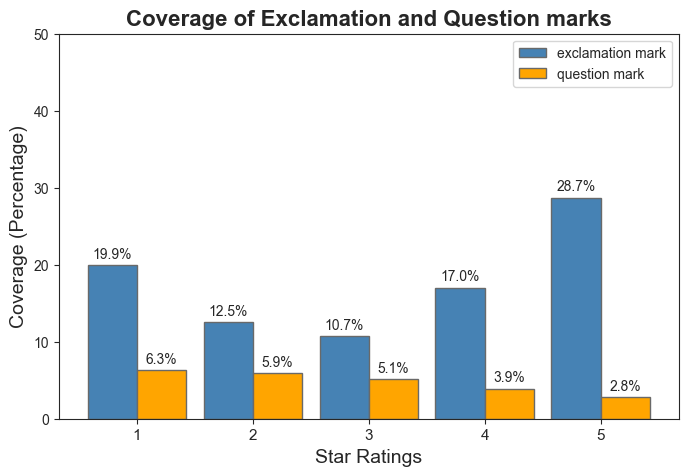

In [66]:
%matplotlib inline
plt.rcParams["figure.figsize"] = (8,5)
sns.set_style("ticks")

x_val = 'star_ratings'
y_list = ['exclamation mark', 'question mark']
ax = df_star_rating_percents.plot(x=x_val, y=y_list,
                      kind='bar', stacked=False, color=['steelblue','orange'],
                      width=0.85, edgecolor='dimgray')

plt.ylim(0,50)
plt.xticks(rotation=0, fontsize=11)
plt.xlabel('Star Ratings', fontsize=14)
plt.ylabel('Coverage (Percentage)', fontsize=14)
plt.title("Coverage of Exclamation and Question marks", fontsize=16, fontweight='bold')

for container in ax.containers:
    ax.bar_label(container, padding=3, fmt='{:.1f}%')
    
plt.show()

<b>Hypothesis Conclusions:</b>
<br><br>
<u>Exclamation marks:</u> I hypothised that we would observer a larger number of One and Five Star Reviews using Exclamation marks in comparison to Two, Three and Four Star Reviews. We can observe from the bar chart above that the number of reviews with exclamation marks starts off at 19.9% for One Star reviews and then drops to 12.5% for Two Star and 10.7% (lowest) for Three Star reviews. This increases to 17% for Four Star and further increases to 28.7% for Five Star reviews. Reviewers are more expressive with dissatisfaction and satisfaction of their products<br><br>

<u>Question marks:</u> We observe that 6.3% of One Star reviews contain Question marks and that metric drops to 5.9% for Two Star, 5.1% for Three Star, 3.9% for Four Star and finally 2.8% for Five Star reviews. Reviewers with the lowest satisfaction (One Star) question the quality/design/support of their product the most.<br><br>

Based on the above observations we can conclude that people who use Exclamation Marks tend to emphasis that dissatisfaction and satisfaction with the product. We also observe that people who use Question Marks tend to ask less questions as their satisfaction with the product increases.
    


Next step use countvectorizer and build word cloud

# *** Older test code beyond this point ***

#### ****** Will check if we need to remove apostrophe separately

4. Remove apostrophe from words in 'review_body_clean' text

In [19]:
df_reviews['review_body_cleaned'] = df_reviews['review_body_cleaned'].apply(lambda x: re.sub("(?<=[a-z])'(?=[a-z])", "",x))

In [21]:
df_reviews[df_reviews['review_body_cleaned'].str.contains("'")].head(3)

,star_rating,review_body,review_body_cleaned
9,5,"I've owned multiple fixed boards over the years, but I much rather stick with individual effect units*** I've purchased a few empty boards and they wound up falling apart, then it's deep six time *** My brother-in-law purchased the GPTBLPWR as a X-Mass gift 5 years ago, and much to my surprise, it's still kicking ass*** I've dropped it a few times, it's been accidentally stepped on a few times, kicked around numerous times, but after all this abuse, she's still rockin' as hard as ever *** Yes, it's heavy, Yes, the power cord is a bit flimsy, but I think I can deal with those negatives*** Actually, I upgraded the power cord to a heavier gauge which only cost me an extra 5 bucks and a little of my time *** I'd totally recommend this product to anyone who is constantly on the move with there gear *** The cool thing about this is that when my bro-in-law purchased it 5 years ago, it was only $89.95 *** To bad guy's, you should have taken a chance back then, you could have saved a little change, but all in all, it's very worth every penny*** You won't be disappointed, I can guarantee it *** Thanks again Amazon / Gator for another job well done ***","ive owned multiple fixed boards over the years, but i much rather stick with individual effect units*** ive purchased a few empty boards and they wound up falling apart, then its deep six time *** my brother-in-law purchased the gptblpwr as a x-mass gift 5 years ago, and much to my surprise, its still kicking ass*** ive dropped it a few times, its been accidentally stepped on a few times, kicked around numerous times, but after all this abuse, shes still rockin' as hard as ever *** yes, its heavy, yes, the power cord is a bit flimsy, but i think i can deal with those negatives*** actually, i upgraded the power cord to a heavier gauge which only cost me an extra 5 bucks and a little of my time *** id totally recommend this product to anyone who is constantly on the move with there gear *** the cool thing about this is that when my bro-in-law purchased it 5 years ago, it was only $89.95 *** to bad guys, you should have taken a chance back then, you could have saved a little change, but all in all, its very worth every penny*** you wont be disappointed, i can guarantee it *** thanks again amazon / gator for another job well done ***"
51,5,"Killer tone, Light weight, and plays like butter. I would like to change the wiring for the neck pickup but it sounds so good like it is I'm afraid to change anything. Other than intonation I haven't moved a screw on this guitar and it's perfect with a set of 10's on it.","killer tone, light weight, and plays like butter. i would like to change the wiring for the neck pickup but it sounds so good like it is im afraid to change anything. other than intonation i havent moved a screw on this guitar and its perfect with a set of 10's on it."
121,4,"This thing will make any room, or any object you place it behind, a LOT more prominent and interesting. The LED behavior manages to be unpredictable yet reactive in a way that makes it feel a bit like a 'toy', in a good way. It's blinding to look right at this thing, and the light is somewhat directional without a reflector to help it out, so you'll want to mount it very carefully and pay attention (whilst standing back) to see how it looks.<br />Great device, lots of fun.","this thing will make any room, or any object you place it behind, a lot more prominent and interesting. the led behavior manages to be unpredictable yet reactive in a way that makes it feel a bit like a 'toy', in a good way. its blinding to look right at this thing, and the light is somewhat directional without a reflector to help it out, so youll want to mount it very carefully and pay attention (whilst standing back) to see how it looks. />great device, lots of fun."


In [24]:
re.sub("(?<=[a-z])'(?=[a-z])", ""," it feel a bit like a 'toy's, in a good way")

' it feel a bit like a toys, in a good way'

#### ***** End apostrophe section

<br><br> Until now we have assumed all reviews are in US English, but we have seen some other languages in the text. What if there are reviews that use Spanish or French or German?

From the PyEnchant library I will use the SpellChecker class to check for words with 'US_en' spelling. I will use a function to check if each body of text in the 'review_body_cleaned' column contains at least 50% of the words in 'US_en'

In [115]:
from enchant.checker import SpellChecker
spc = SpellChecker("en_US")

In [116]:
def check_if_us_en(txt, spc=spc):
    # from enchant.checker import SpellChecker
    # spc = SpellChecker("en_US")
    spc.set_text(txt)
    txt_len = len(txt.split(" "))
    # print("text length: {}".format(txt_len))
    word_errors = []
    for err in spc:
        word_errors.append(err.word)

    num_errors = len(word_errors)
    # print("number of errors: {}".format(num_errors))

    if txt_len == 1:
        if len(word_errors) == 1:
            return False
        else:
            return True
    else:
        if len(word_errors) <= (txt_len//2):
            return True
        else:
            return False



In [ ]:
df_reviews_word_count.head(5)

In [50]:
#df_reviews_word_count['is_US_en'] = df_reviews_word_count['review_body_cleaned'].apply(lambda x: check_if_us_en(x))

In [35]:
us_en1 = "this is some rdm text"
sp1 = "el producto no fue de mi satisfacci n es verdad que es muy econ mico pero de haber sabido lo endeble que era no"
fr1 = "je suis un petit garcon"

In [37]:
from enchant.checker import SpellChecker

In [38]:
chkr = SpellChecker("en_US")

In [90]:
chkr.set_text("thanks lts")

In [76]:
chkr.set_text(sp1)

In [91]:
word_errors = []
for err in chkr:
    word_errors.append(err.word)

print(len(word_errors))
print(word_errors)

1
['lts']


In [45]:
chkr.word

'erors'

In [93]:
1//2

0

In [111]:
from enchant.checker import SpellChecker
spc = SpellChecker("en_US")

In [112]:
def check_if_us_en(txt, spc=spc):
    # from enchant.checker import SpellChecker
    # spc = SpellChecker("en_US")
    spc.set_text(txt)
    txt_len = len(txt.split(" "))
    print("text length: {}".format(txt_len))
    word_errors = []
    for err in spc:
        word_errors.append(err.word)

    num_errors = len(word_errors)
    print("number of errors: {}".format(num_errors))

    if txt_len == 1:
        if len(word_errors) == 1:
            return False
        else:
            return True
    else:
        if len(word_errors) <= (txt_len//2):
            return True
        else:
            return False



In [114]:
check_if_us_en("singing the giggling")

text length: 3
number of errors: 0


True

In [87]:
df_reviews_word_count[df_reviews_word_count['review_body_word_count']==2]

,star_rating,review_body,review_body_cleaned,review_body_word_count
29,5,Works fine.,works fine,2
34,5,GREAT QUALITY,great quality,2
44,5,love them,love them,2
75,5,Good price!,good price,2
78,5,Thanks!<br /> LTS,thanks lts,2
...,...,...,...,...
893398,3,[[VIDEOID:15949891]],videoid 15949891,2
893504,5,[[VIDEOID:15799701]],videoid 15799701,2
893776,5,[[VIDEOID:15397221]],videoid 15397221,2
896173,5,very good,very good,2


In [50]:
262/904040

0.000289810185390027

In [36]:
'it.<br />Yamaha PA6 Power Adapter'.isascii()

True

In [37]:
# check all records that are not ascii

In [38]:
df_reviews['is_ascii'] = df_reviews['review_body'].apply(lambda x: x.isascii())

In [41]:
df_reviews['is_ascii'].unique()

array([ True, False])

In [43]:
df_reviews[df_reviews['is_ascii']==False].shape[0]

6736

In [44]:
df_reviews[df_reviews['is_ascii']==False].head(5)

,star_rating,review_body,review_body_cleaned,review_body_word_count,is_ascii
28,5,"I am always looking for unique items that will WOW my grandchildren when they come to visit. This Magic Ball light is fun; it fills a room or tent with light and the automatic sound activation has my Grandchildren singing their hearts out, then giggling and laughing. Priceless!<br /><br />This has been thoroughly tested and approved by all of my grandchildren over the last couple of months and never seems to lose its appeal. It would make a nice inexpensive gift for any child for their room.<br /><br />1. RoHS, CE certified<br /><br />2. This is made of heavy plastic and has a 5 inch diameter and is 5 1/8th inches tall, it has a clear dome and colored LED lights shoot from the dome in addition to a ring of LED lights around the bottom which in combination create a two dimensional light show.<br /><br />3. The bottom is made with 2 indented screw holes and an indentation for the cord so it is easy to hang on the wall or ceiling, or just plug it in and set it on a stand.<br /><br />4. There are a total of 51 LED lights in Red, Green and Blue that rotate and fill the room with lights, for its price and size this is a very nice little light with a big light show that my Grandchildren love.<br /><br />5. There is also automated sound activation that changes the light show to match the music or at my house the songs my grandchildren sing to get the lights to speed up and change. This sound activation is not as sensitive as some lights I have tried and doesn’t pick up every nuance however it is a wonderful feature and I love hearing my three year old singing. The giggling and laughing Priceless.<br /><br />6. There are two things that I would change on this, the cord is only 35 inches long and there is no on/off switch or sound activation switch. I have it plugged into a surge protector with a switch on it so it is not constantly being plugged in and unplugged.<br /><br />Received a free sample for evaluation and unbiased review.",i am always looking for unique items that will wow my grandchildren when they come to visit this magic ball light is fun it fills a room or tent with light and the automatic sound activation has my grandchildren singing their hearts out then giggling and laughing priceless this has been thoroughly tested and approved by all of my grandchildren over the last couple of months and never seems to lose its appeal it would make a nice inexpensive gift for any child for their room 1 rohs ce certified 2 this is made of heavy plastic and has a 5 inch diameter and is 5 1 8th inches tall it has a clear dome and colored led lights shoot from the dome in addition to a ring of led lights around the bottom which in combination create a two dimensional light show 3 the bottom is made with 2 indented screw holes and an indentation for the cord so it is easy to hang on the wall or ceiling or just plug it in and set it on a stand 4 there are a total of 51 led lights in red green and blue that rotate and fill the room with lights for its price and size this is a very nice little light with a big light show that my grandchildren love 5 there is also automated sound activation that changes the light show to match the music or at my house the songs my grandchildren sing to get the lights to speed up and change this sound activation is not as sensitive as some lights i have tried and doesn t pick up every nuance however it is a wonderful feature and i love hearing my three year old singing the giggling and laughing priceless 6 there are two things that i would change on this the cord is only 35 inches long and there is no on off switch or sound activation switch i have it plugged into a surge protector with a switch on it so it is not constantly being plugged in and unplugged received a free sample for evaluation and unbiased review,359,False
263,2,"Good sound, but they fit awkwardly on my ears. Not very comfortable... I probably wouldn't enjoy usin

In [45]:
df_reviews[df_reviews['is_ascii']==False].tail(5)

,star_rating,review_body,review_body_cleaned,review_body_word_count,is_ascii
901554,5,"I literally got 'the shakes' when I played my first riff with the PODxt. The sound is so incredible, you really won't believe what you're hearing. If you've listened to a good Bose© system, and how you were blown away by the sound; it's the same feeling.<br /><br />I'd consider myself a 'Tech Guru' along with 'Musician', and honestly I was a bit overwhelmed when I began setting up and using the PODxt, but I got the hang of it pretty quick. If you've ever used a big Amp with a bunch of effects and buttons, it's sort of like that.<br /><br />Of of the best features I found on the PODxt is the 'Line 6 Edit' software ([...]), and Mac (all OS X including Tiger) compatible. I can edit tones quickly and easily, it's all so seamless, you'll be amazed.<br />The other amazing feature is the website that links with Line 6 Edit; I can go to the site, and type the name of a song I'm going to play, and instantly a new tone (designed perfectly for that song) is in the editor, ready to be transferred to my PODxt.<br /><br />This is without a doubt the best 'Bang For Your Buck' deal around - if you're into Guitar and making great music, the PODxt if for you.<br /><br />~Rob Hedrick",i literally got the shakes when i played my first riff with the podxt the sound is so incredible you really wont believe what youre hearing if youve listened to a good bose system and how you were blown away by the sound its the same feeling id consider myself a tech guru along with musician and honestly i was a bit overwhelmed when i began setting up and using the podxt but i got the hang of it pretty quick if youve ever used a big amp with a bunch of effects and buttons its sort of like that of of the best features i found on the podxt is the line 6 edit software and mac all os x including tiger compatible i can edit tones quickly and easily its all so seamless youll be amazed the other amazing feature is the website that links with line 6 edit i can go to the site and type the name of a song im going to play and instantly a new tone designed perfectly for that song is in the editor ready to be transferred to my podxt this is without a doubt the best bang for your buck deal around if youre into guitar and making great music the podxt if for you rob hedrick,217,False
901698,3,"This a good guitar. It is a shame it looks like and is called a Les Paul, which will immediatly force oyu to draw comparisons with the \\""real thing\\"". For a £350 guitar, this is very good. They play nicely, look good, and probalby won't let you down. You won't be dissapointed if you got one of these. I've taken the time to undertake an extensive comparison of the Gibson and Epiphone Les Paul. You can see this at my website dub dub dub dot masht dot com. I hope this helps. To summarise, there IS a big difference in the tone, there IS a big different in teh aesthetics, and there IS a big difference in the build quality and the auality of the components. It is NOT the same thing made in a different place.",this a good guitar it is a shame it looks like and is called a les paul which will immediatly force oyu to draw comparisons with the real thing for a 350 guitar this is very good they play nicely look good and probalby wont let you down you wont be dissapointed if you got one of these ive taken the time to undertake an extensive comparison of the gibson and epiphone les paul you can see this at my website dub dub dub dot masht dot com i hope this helps to summarise there is a big difference in the tone there is a big different in teh aesthetics and there is a big difference in the build quality and the auality of the components it is not the same thing made in a different place,137,False
901775,2,"El producto no fue de mi satisfacción. Es verdad que es muy económico, pero de haber sabido lo endeble que era no lo hubiera comprado. Parece un estuche de \\""utilería\\"", como para usarse en una obra de tea

<br><br><br>

### Word Clouds

In [2]:
import re
import pattern 
from pattern.en import lemma
from sklearn.feature_extraction.text import TfidfVectorizer

In [3]:
from wordcloud import WordCloud
from matplotlib.pyplot import figure

In [4]:
data_file = "~/Documents/python/project02/amazon_musical_instru_star_rev_only.tsv"
col_list = ["star_rating","review_body"]
#reviews_df = pd.read_csv(data_file, sep="\t", usecols=col_list, low_memory=False)
reviews_df = pd.read_csv(data_file, sep="\t", usecols=col_list, nrows=20000)

In [5]:
reviews_df['star_rating'] = reviews_df['star_rating'].fillna(0)
reviews_df['review_body'] = reviews_df['review_body'].fillna('')

In [6]:
reviews_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20000 entries, 0 to 19999
Data columns (total 2 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   star_rating  20000 non-null  int64 
 1   review_body  20000 non-null  object
dtypes: int64(1), object(1)
memory usage: 312.6+ KB


In [7]:
# stats on the star rating for the 20,000 records
print("Min star:", reviews_df['star_rating'].min())
print("Max star:", reviews_df['star_rating'].max())
print("Average star:", reviews_df['star_rating'].mean())
print("Median star:", reviews_df['star_rating'].median())

Min star: 1
Max star: 5
Average star: 4.28765
Median star: 5.0


In [8]:
def count_words(data):
    return len(data.split())

In [9]:
def count_excla(data):
    return data.count("!")

In [10]:
def count_ques(data):
    return data.count("?")

In [11]:
def cleanup_docs(docs):
    new_docs = []
    for doc in docs:
        doc = doc.lower()
        doc = re.sub('<br',' ',doc) # removing <br from the text
        doc = re.sub('http\S+','',doc) # removing all http links
        doc = re.sub("(?<=[a-z])'(?=[a-z])", "", doc) # remove apostrophe
        doc = re.sub("[^A-Za-z]+", " ", doc) # removing special characters
        new_docs.append(doc)
    
    return new_docs

In [12]:
# returns a dictionary with the word and number of occurances
def get_uniq_words(data):
    word_counter = {}
    for word in data:
        word_counter[word] = word_counter.get(word, 0) + 1
        
    return(word_counter)

In [13]:
def count_excla_review(data):
    return data[data['num_exclamations_marks'] != 0].count()

In [14]:
def count_ques_review(data):
    return data[data['num_questions_marks'] != 0].count()

In [15]:
def calc_percent(numer, denom):
    return int((numer/denom)*100)

In [16]:
def rm_stopwords(list_data, stop_data):
    list_data = [word for word in list_data if word not in stop_data]
    return list_data

In [175]:
def lemmatize_tokens(data):
    lemm_list = []
    for item in data:
        lemm_list.append(" ".join([lemma(wd) for wd in item.split()]))

    return lemm_list

In [18]:
# using bi-grams, sparse matrix and eliminating words with 1 occurance
def create_tfidf_matrix(docs_list, all_stopwords):
    tfidf_vectorizer=TfidfVectorizer(use_idf=True, analyzer='word', stop_words=all_stopwords,
                                    ngram_range=(2,2), min_df=2)

    tfidf_vectorizer_vectors=tfidf_vectorizer.fit_transform(docs_list)
    
    # calculating the sum of the vocab vectors column 
    vocab_list = []
    vocab_list = np.array(tfidf_vectorizer_vectors.sum(axis=0))[0].tolist()
    # get the vocabulary with position values into a dict
    vocab_dict = {}
    vocab_dict = tfidf_vectorizer.vocabulary_
    # create dict with vocab and vector sum value
    tfidf_dict={}
    for key, val in vocab_dict.items():
        tfidf_dict[key] = vocab_list[val]
        
    return tfidf_dict

In [96]:
def sort_tokens_tf(tokens_dict):
    return sorted(tokens_dict.items(), key=lambda x: x[1], reverse=True)

In [218]:
def create_wordcloud(data):
    wordcloud = WordCloud(width=6000, height=4000, relative_scaling=1, background_color='white',
                          max_words=40).generate_from_frequencies(data)
    return wordcloud

In [20]:
domain_stopwords ={"amazon","bought","purchase","purchased","ordered","buy","facebook","www",
                   "google","order","amazoncom", "amazons", "amazonseller", "amazonthe"}

In [130]:
review_stopwords = {"the","i","a","and","to","of","this","for","in","that","on","my",
                     "you","they","have","so","as","are","at","be","product","is",
                    "had","would","if","all","get","them","these","from","its","when","or",
                     "me","will","back","an","sound","were","do","what","guitar","time",
                    "did","money","about","your","two","we","first","could","was",
                    "because","tried","return","there","which","made","any","now","am","then",
                    "by","thing","also","receive","im","way","their","item","way","before",
                     "after","power","into","came","put","piece","been","something",
                    "both","month","through","unit","ive","thi","aa","aaa",
                    "string","set","play","another","see","think","want","how","reviews",
                    "years","using","still","should","day","said","where","review","week",
                    "go","going","hold","try","went","every","it","etc","li","ion"}
#print(len(review_stopwords))

In [22]:
# Count number of words for each review and add a columanalyzer='word',n to the dataframe
word_count = []
excla_count = []
ques_count = []
for index, row in reviews_df.iterrows():
    word_count.append(count_words(reviews_df.iloc[index]['review_body']))
    excla_count.append(count_excla(reviews_df.iloc[index]['review_body']))
    ques_count.append(count_ques(reviews_df.iloc[index]['review_body']))
    
reviews_df["num_of_words"] = word_count
reviews_df["num_exclamations_marks"] = excla_count
reviews_df["num_questions_marks"]= ques_count

In [ ]:
# Stats on Word Count for all reviews
print("Stats on word count for all reviews")
print("-----------------------------------")
print("Min number of words:", reviews_df['num_of_words'].min())
print("Max number of words:", reviews_df['num_of_words'].max())
print("Average number of words:", reviews_df['num_of_words'].mean())
print("Median number of words:", reviews_df['num_of_words'].median())

In [ ]:
# Stats on number of exclamation and question marks for all reviews
print("Stats on exclamation marks for all reviews")
print("-----------------------------------")
print("Min number of exclamation marks:", reviews_df['num_exclamations_marks'].min())
print("Max number of exclamation marks:", reviews_df['num_exclamations_marks'].max())
print("Average number of exclamation marks:", reviews_df['num_exclamations_marks'].mean())
print("Median number of exclamation marks:", reviews_df['num_exclamations_marks'].median())
print('\n')
print("Stats on question marks for all reviews")
print("-----------------------------------")
print("Min number of question marks:", reviews_df['num_questions_marks'].min())
print("Max number of question marks:", reviews_df['num_questions_marks'].max())
print("Average number of question marks:", reviews_df['num_questions_marks'].mean())
print("Median number of question marks:", reviews_df['num_questions_marks'].median())

In [23]:
# number of reviews for each star rating
reviews_df.groupby(['star_rating']).count()

,review_body,num_of_words,num_exclamations_marks,num_questions_marks
star_rating,,,,
1,1482,1482,1482,1482
2,817,817,817,817
3,1402,1402,1402,1402
4,3064,3064,3064,3064
5,13235,13235,13235,13235


In [24]:
# analyzing One Star reviews
onestar_reviews_df = reviews_df[reviews_df['star_rating'] == 1]
#onestar_reviews_df.info()

In [25]:
# analyzing Two Star reviews
twostar_reviews_df = reviews_df[reviews_df['star_rating'] == 2]
#twostar_reviews_df.info()

In [26]:
# analyzing Three Star reviews
threestar_reviews_df = reviews_df[reviews_df['star_rating'] == 3]
#threestar_reviews_df.info()

In [27]:
# analyzing Four Star reviews
fourstar_reviews_df = reviews_df[reviews_df['star_rating'] == 4]
#fourstar_reviews_df.info()

In [28]:
# analyzing Five Star reviews
fivestar_reviews_df = reviews_df[reviews_df['star_rating'] == 5]
#fivestar_reviews_df.info()

# Hypothesis 1:

<b>Exclamation Marks used in reviews:</b><br>
A substantial percentage of One Star and Five Star reviews will have Exclamation Marks. Two, Three and Four Star reviews will have a lower percentage as reviewers are less expressive 

<b>Question Marks used in reviews:</b></br>
One Star reviews will have the largest percentage of Question Marks used. The percentage will drop through Two to Five Star reviews as reviewers will likely have less questions about the quality of the product.

In [29]:
# counting number of exclamation and question marks for each star review category
onestar_excla_series = count_excla_review(onestar_reviews_df)
onestar_excla_count_val = calc_percent(onestar_excla_series['num_exclamations_marks'],
                                       onestar_reviews_df['star_rating'].count())
print("% of Exclamation Marks in One Star reviews:", onestar_excla_count_val,)
onestar_ques_series = count_ques_review(onestar_reviews_df)
onestar_ques_count_val = calc_percent(onestar_ques_series['num_questions_marks'],
                                      onestar_reviews_df['star_rating'].count())
print("% of Question Marks in One Star reviews:",onestar_ques_count_val, "\n")
twostar_excla_series = count_excla_review(twostar_reviews_df)
twostar_excla_count_val = calc_percent(twostar_excla_series['num_exclamations_marks'],
                                       twostar_reviews_df['star_rating'].count())
print("% of Exclamation Marks in Two Star reviews:",twostar_excla_count_val)
twostar_ques_series = count_ques_review(twostar_reviews_df)
twostar_ques_count_val = calc_percent(twostar_ques_series['num_questions_marks'],
                                      twostar_reviews_df['star_rating'].count())
print("% of Question Marks in Two Star reviews:", twostar_ques_count_val, "\n")
threestar_excla_series = count_excla_review(threestar_reviews_df)
threestar_excla_count_val = calc_percent(threestar_excla_series['num_exclamations_marks'],
                                         threestar_reviews_df['star_rating'].count())
print("% of Exclamation Marks in Three Star reviews:",threestar_excla_count_val)
threestar_ques_series = count_ques_review(threestar_reviews_df)
threestar_ques_count_val = calc_percent(threestar_ques_series['num_questions_marks'],
                                        threestar_reviews_df['star_rating'].count())
print("% of Question Marks in One Star reviews:", threestar_ques_count_val, "\n")
fourstar_excla_series = count_excla_review(fourstar_reviews_df)
fourstar_excla_count_val = calc_percent(fourstar_excla_series['num_exclamations_marks'],
                                        fourstar_reviews_df['star_rating'].count())
print("% of Exclamation Marks in Four Star reviews:",fourstar_excla_count_val)
fourstar_ques_series = count_ques_review(fourstar_reviews_df)
fourstar_ques_count_val = calc_percent(fourstar_ques_series['num_questions_marks'],
                                       fourstar_reviews_df['star_rating'].count())
print("% of Question Marks in One Star reviews:", fourstar_ques_count_val, "\n")
fivestar_excla_series = count_excla_review(fivestar_reviews_df)
fivestar_excla_count_val = calc_percent(fivestar_excla_series['num_exclamations_marks'],
                                        fivestar_reviews_df['star_rating'].count())
print("% of Exclamation Marks in Five Star reviews:",fivestar_excla_count_val)
fivestar_ques_series = count_ques_review(fivestar_reviews_df)
fivestar_ques_count_val = calc_percent(fivestar_ques_series['num_questions_marks'],
                                       fivestar_reviews_df['star_rating'].count())
print("% of Question Marks in One Star reviews:", fivestar_ques_count_val, "\n")

% of Exclamation Marks in One Star reviews: 18
% of Question Marks in One Star reviews: 4 

% of Exclamation Marks in Two Star reviews: 9
% of Question Marks in Two Star reviews: 3 

% of Exclamation Marks in Three Star reviews: 9
% of Question Marks in One Star reviews: 3 

% of Exclamation Marks in Four Star reviews: 14
% of Question Marks in One Star reviews: 2 

% of Exclamation Marks in Five Star reviews: 27
% of Question Marks in One Star reviews: 1 



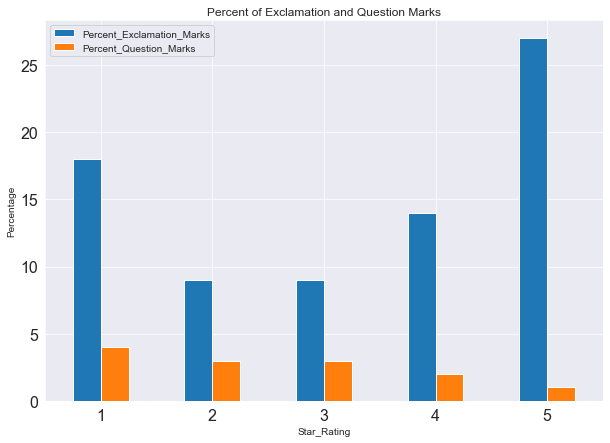

In [30]:
# Plot bar chart comparing exclamation and question marks by review star rating

allstar_e_q_count = {'Star_Rating':[1,2,3,4,5],
                     'Percent_Exclamation_Marks':[onestar_excla_count_val,twostar_excla_count_val,
                                               threestar_excla_count_val,fourstar_excla_count_val,
                                               fivestar_excla_count_val],
                    'Percent_Question_Marks':[onestar_ques_count_val,twostar_ques_count_val,
                                           threestar_ques_count_val,fourstar_ques_count_val,
                                           fivestar_ques_count_val]}

allstar_excla_ques_count_df = pd.DataFrame(allstar_e_q_count)
allstar_excla_ques_count_df = allstar_excla_ques_count_df.set_index('Star_Rating')

#plt.figure(figsize=(10,10))
sns.set_style("dark")
allstar_excla_ques_count_df.plot.bar(title="Percent of Exclamation and Question Marks",
                                    figsize=(10,7), fontsize=16, grid=True)
plt.ylabel("Percentage")
plt.xticks(rotation=0, horizontalalignment="center")
plt.show()

<b>Results:</b></br>
As observed from the graph above, One and Five Star reviews are have the largest percentage of Exclamation Marks. One Star reviews at 18% and Five Star reviews at 27%. This proves that reviewers are more expressive with dissatisfaction and satisfaction of their products.

With regards to Question Marks, we observe that reviewers with the lowest satisfaction (One Star) question the quality/design/support of their product the most. One Star reviews had 4% Question Marks which dropped to 1% for Five Star reviews.

In [31]:
# all reviews with 5 or less words
five_less_word_reviews_df = reviews_df[reviews_df['num_of_words'] <= 5]
five_less_word_reviews_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 4597 entries, 2 to 19995
Data columns (total 5 columns):
 #   Column                  Non-Null Count  Dtype 
---  ------                  --------------  ----- 
 0   star_rating             4597 non-null   int64 
 1   review_body             4597 non-null   object
 2   num_of_words            4597 non-null   int64 
 3   num_exclamations_marks  4597 non-null   int64 
 4   num_questions_marks     4597 non-null   int64 
dtypes: int64(4), object(1)
memory usage: 215.5+ KB


In [ ]:
# Number of reviews with 5 or less words per star rating
five_less_word_reviews_df.groupby(['star_rating']).count()

In [32]:
# all reviews with more than 5 words
mt_five_word_reviews_df = reviews_df[reviews_df['num_of_words'] > 5]
mt_five_word_reviews_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 15403 entries, 0 to 19999
Data columns (total 5 columns):
 #   Column                  Non-Null Count  Dtype 
---  ------                  --------------  ----- 
 0   star_rating             15403 non-null  int64 
 1   review_body             15403 non-null  object
 2   num_of_words            15403 non-null  int64 
 3   num_exclamations_marks  15403 non-null  int64 
 4   num_questions_marks     15403 non-null  int64 
dtypes: int64(4), object(1)
memory usage: 722.0+ KB


In [33]:
# Stats for reviews with more than 5 words
print("Max number of words:", mt_five_word_reviews_df['num_of_words'].max())
print("Average number of words:", mt_five_word_reviews_df['num_of_words'].mean())
print("Median number of words:", mt_five_word_reviews_df['num_of_words'].median())

Max number of words: 2163
Average number of words: 53.15204830227878
Median number of words: 26.0


In [34]:
# More than 5 word reviews by Star Rating
grouped_review_df = mt_five_word_reviews_df.groupby(['star_rating']).count()
grouped_review_df.head()

,review_body,num_of_words,num_exclamations_marks,num_questions_marks
star_rating,,,,
1,1309,1309,1309,1309
2,758,758,758,758
3,1238,1238,1238,1238
4,2536,2536,2536,2536
5,9562,9562,9562,9562


In [35]:
# One star reviews with more than 5 words
#mt_five_word_reviews_df.tail()
mtfive_1star_reviews_df = mt_five_word_reviews_df[mt_five_word_reviews_df['star_rating'] == 1].reset_index(drop=True)
#mtfive_1star_reviews_df.info()

In [36]:
# Two star reviews with more than 5 words
mtfive_2star_reviews_df = mt_five_word_reviews_df[mt_five_word_reviews_df['star_rating'] == 2].reset_index(drop=True)
#mtfive_2star_reviews_df.info()

In [37]:
# Three star reviews with more than 5 words
mtfive_3star_reviews_df = mt_five_word_reviews_df[mt_five_word_reviews_df['star_rating'] == 3].reset_index(drop=True)
#mtfive_3star_reviews_df.info()

In [38]:
# Four star reviews with more than 5 words
mtfive_4star_reviews_df = mt_five_word_reviews_df[mt_five_word_reviews_df['star_rating'] == 4].reset_index(drop=True)
#mtfive_4star_reviews_df.info()

In [39]:
# Five star reviews with more than 5 words
mtfive_5star_reviews_df = mt_five_word_reviews_df[mt_five_word_reviews_df['star_rating'] == 5].reset_index(drop=True)
#mtfive_5star_reviews_df.info()

<b>Creating one star / review stopwords set</b>

In [187]:
# extracting docs and cleaning up for one star reviews
onestar_docs_list = []

onestar_docs_list = cleanup_docs(mtfive_1star_reviews_df['review_body'])
#print(onestar_docs_list[:5])

In [188]:
# Lemmatize one star docs
onestar_docs_list = lemmatize_tokens(onestar_docs_list)
#print(onestar_docs_list[1010:1020])

In [189]:
# extracting words/tokens from one star docs
onestar_word_list = []
for doc in onestar_docs_list:
    onestar_word_list.extend(doc.split())
    
print(len(onestar_word_list))

64077


In [190]:
# remove Domain Stop words
onestar_word_list = rm_stopwords(onestar_word_list, domain_stopwords)
print(len(onestar_word_list))

63398


In [191]:
# remove review Stop words
onestar_word_list = rm_stopwords(onestar_word_list, review_stopwords)
print(len(onestar_word_list))

31833


In [192]:
# set of unique OneStar tokens
onestar_uniq_words = {}
onestar_uniq_words = get_uniq_words(onestar_word_list)
#print(onestar_uniq_words)
print(len(onestar_uniq_words))

3937


In [193]:
# sorting dictionary by values in descending order
onestar_uniq_sorted = sorted(onestar_uniq_words.items(), key=lambda x: x[1], reverse=True)


<b>----- Creating docs list for 2 - 5 star reviews -----</b>

In [194]:
# extracting docs and cleaning up for two star reviews
twostar_docs_list = []
twostar_docs_list = cleanup_docs(mtfive_2star_reviews_df['review_body'])

In [195]:
# Lemmatize two star docs
twostar_docs_list = lemmatize_tokens(twostar_docs_list)

In [196]:
# extracting docs and cleaning up for three star reviews
threestar_docs_list = []
threestar_docs_list = cleanup_docs(mtfive_3star_reviews_df['review_body'])

In [197]:
# Lemmatize three star docs
threestar_docs_list = lemmatize_tokens(threestar_docs_list)

In [198]:
# extracting docs and cleaning up for four star reviews
fourstar_docs_list = []
fourstar_docs_list = cleanup_docs(mtfive_4star_reviews_df['review_body'])

In [199]:
# Lemmatize four star docs
fourstar_docs_list = lemmatize_tokens(fourstar_docs_list)

In [200]:
# extracting docs and cleaning up for five star reviews
fivestar_docs_list = []
fivestar_docs_list = cleanup_docs(mtfive_5star_reviews_df['review_body'])

In [201]:
# Lemmatize two star docs
fivestar_docs_list = lemmatize_tokens(fivestar_docs_list)

<b>----------- TF-IDF --------------</b>

In [202]:
all_stopwords = {}
all_stopwords = domain_stopwords.union(review_stopwords)

In [203]:
onestar_hi_freq_dict = {}
onestar_hi_freq_dict = create_tfidf_matrix(onestar_docs_list, all_stopwords)

In [204]:
twostar_hi_freq_dict = {}
twostar_hi_freq_dict = create_tfidf_matrix(twostar_docs_list, all_stopwords)

In [205]:
threestar_hi_freq_dict = {}
threestar_hi_freq_dict = create_tfidf_matrix(threestar_docs_list, all_stopwords)

In [206]:
fourstar_hi_freq_dict = {}
fourstar_hi_freq_dict = create_tfidf_matrix(fourstar_docs_list, all_stopwords)

In [207]:
fivestar_hi_freq_dict = {}
fivestar_hi_freq_dict = create_tfidf_matrix(fivestar_docs_list, all_stopwords)

In [63]:
# twostar_hi_freq_dict = {}
# twostar_hi_freq_dict = twostar_tfidf_df.sum().sort_values(ascending=False).to_dict()

NameError: name 'twostar_tfidf_df' is not defined

# -------- Word Cloud -------------

In [223]:
wordcloud_one = create_wordcloud(onestar_hi_freq_dict)

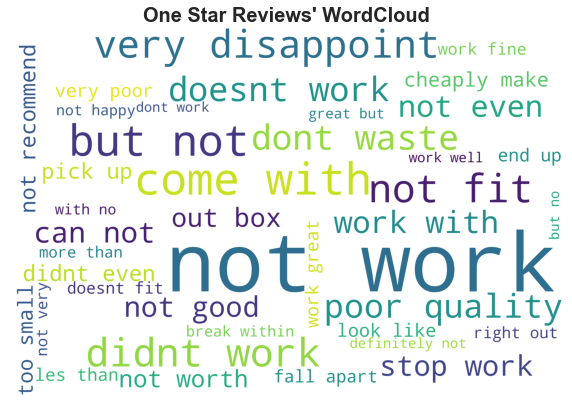

In [224]:
# One Star wordcloud

plt.figure(figsize=(10,7))
plt.title("One Star Reviews' WordCloud",fontsize=20, fontweight='bold')
plt.imshow(wordcloud_one)
plt.axis("off")

plt.show()

In [225]:
wordcloud_two = create_wordcloud(twostar_hi_freq_dict)

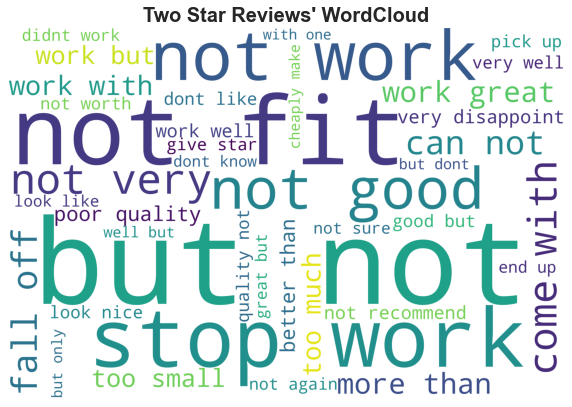

In [226]:
# Two Star wordcloud

plt.figure(figsize=(10,7))
plt.title("Two Star Reviews' WordCloud",fontsize=20, fontweight='bold')
plt.imshow(wordcloud_two)
plt.axis("off")

plt.show()

In [227]:
wordcloud_three = create_wordcloud(threestar_hi_freq_dict)

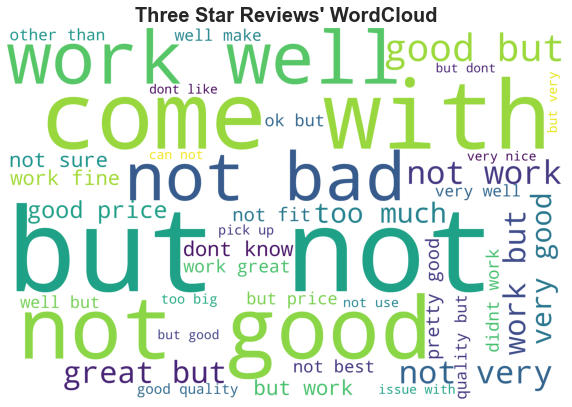

In [228]:
# Three Star wordcloud

plt.figure(figsize=(10,7))
plt.title("Three Star Reviews' WordCloud",fontsize=20, fontweight='bold')
plt.imshow(wordcloud_three)
plt.axis("off")

plt.show()

In [214]:
wordcloud_four = create_wordcloud(fourstar_hi_freq_dict)

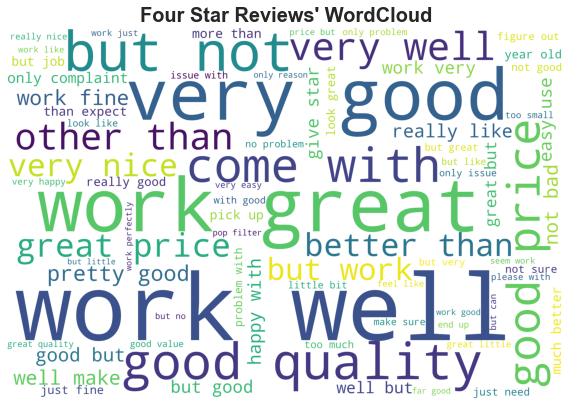

In [222]:
# Four Star wordcloud

plt.figure(figsize=(10,7))
plt.title("Four Star Reviews' WordCloud",fontsize=20, fontweight='bold')
plt.imshow(wordcloud_four)
plt.axis("off")

plt.show()

In [219]:
wordcloud_five = create_wordcloud(fivestar_hi_freq_dict)

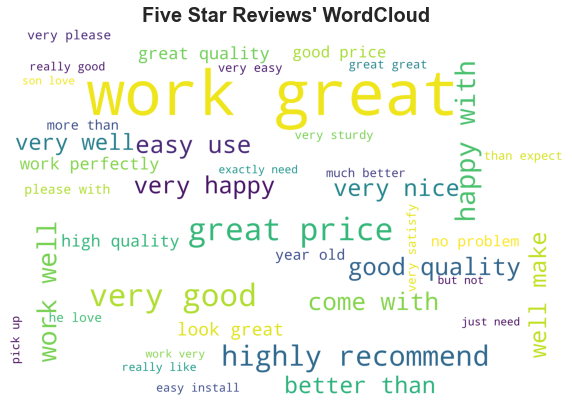

In [221]:
# Five star wordcloud

plt.figure(figsize=(10,7))
plt.title("Five Star Reviews' WordCloud",fontsize=20, fontweight='bold')
plt.imshow(wordcloud_five)
plt.axis("off")

plt.show()

Analyzing the entire dataset for a classifier

In [84]:
mt_five_word_reviews_df[['star_rating','review_body']]

,star_rating,review_body
0,3,"Works very good, but induces ALOT of noise."
1,5,Nice headphones at a reasonable price.
3,5,I purchase these for a friend in return for pl...
5,5,Used to cool equipment inside credenzas. Work...
6,2,Note- Does not Fit Epiphone SG Special! Mine i...
...,...,...
19994,4,"Decently built, very good quality for the pric..."
19996,5,Shiping was fast this is a high quality measu...
19997,5,Love it sounds great and easy to play a must f...
19998,4,"Could be a bit bright on other ukuleles, but t..."


In [176]:
#cleaning up text in review body and adding to list
review_body_list = []
review_body_list = cleanup_docs(mt_five_word_reviews_df['review_body'])
#review_body_list = lemmatize_tokens(review_body_list)

In [177]:
review_body_list = lemmatize_tokens(review_body_list)

In [174]:
#print(review_body_list[:2])
#print(lemmatize_tokens(review_body_list[:2]))
data = ['this is to has or not to be was', 'you him her flew fly flies mic mics work works']
lemm_list = []
for lst in data:
    lemm_list.append(" ".join([lemma(wd) for wd in lst.split()]))


print(lemm_list)

['thi be to have or not to be be', 'you him her fly fly fly mic mic work work']


In [178]:
review_body_list[:5]

['work very good but induce alot of noise',
 'nice headphone at a reasonable price',
 'i purchase these for a friend in return for play them for my father and other folk at a local retirement home thank you r bngr',
 'used to cool equipment inside credenza work great',
 'note do not fit epiphone sg special mine be circa model and it will not fill the space between the humbucker completely everythe else be great and good craftmanship otherwise i have to add my own custom make filler plate to complete the build i have not be able to find thi style pick guard that will fit my guitar with proper space between humbucker without a custom price and have to send your guitar out good price but be prepare to do some custom work yourself']

In [179]:
all_tfidf=TfidfVectorizer(use_idf=True, analyzer='word', stop_words=all_stopwords,
                                    ngram_range=(2,2), min_df=2)

all_tfidf_vectors = all_tfidf.fit_transform(review_body_list)
    
print(len(all_tfidf.vocabulary_))
all_vocab_list = all_tfidf.get_feature_names()
all_vocab_sum = np.array(all_tfidf_vectors.sum(axis=0))[0].tolist()
all_vocab_dict = dict(zip(all_vocab_list,all_vocab_sum))
sorted_vocab = sort_tokens_tf(all_vocab_dict)
print(sorted_vocab[:20])
print(len(all_tfidf.stop_words_))


46857
[('work great', 145.50602948914994), ('very good', 85.36591783346601), ('work well', 84.8812955821191), ('come with', 74.4544523563381), ('great price', 71.69568073554608), ('happy with', 64.69271716332682), ('good quality', 63.336459813918495), ('but not', 59.41240662036099), ('very well', 59.139068218727424), ('better than', 57.3952839384974), ('very nice', 57.374248897251015), ('highly recommend', 57.117173025597864), ('well make', 55.31188876008019), ('easy use', 55.22349375105342), ('very happy', 50.931007192769385), ('good price', 48.740184102252684), ('look great', 42.210247511625234), ('not work', 40.31623393412736), ('more than', 38.423776436524825), ('great quality', 37.62856131189749)]
175687


In [230]:
all_tfidf.stop_words_

{'second operation',
 'noisy higher',
 'stand school',
 'upright daughter',
 'machine while',
 'provide only',
 'must train',
 'realize second',
 'ability strap',
 'preamp anyone',
 'sort unusual',
 'handy mackie',
 'fingering breathe',
 'test against',
 'description plain',
 'regardles position',
 'enjoy he',
 'compare build',
 'down throw',
 'foil trick',
 'position anyway',
 'novelty gift',
 'like pre',
 'ready throw',
 'reed amaze',
 'test second',
 'world perfect',
 'sorenson beautiful',
 'effect course',
 'search thoroughly',
 'lock headphone',
 'spur drum',
 'koa resonant',
 'very subtle',
 'visual visual',
 'complaint whether',
 'somewhat lack',
 'maple stick',
 'no microphone',
 'package correctly',
 'make popsicle',
 'design tape',
 'excite player',
 'lot solution',
 'piezo simply',
 'length dr',
 'leane fine',
 'control program',
 'school bit',
 'with grace',
 'over colore',
 'card loader',
 'connection stand',
 'part pickup',
 'minute no',
 'system next',
 'stellar battery'

In [180]:
idf_score = all_tfidf.idf_
tfidf_token_dict = dict(zip(all_tfidf.get_feature_names(),idf_score))

In [181]:
tfidf_token_dict

{'ab plastic': 9.25608813381491,
 'ability adjust': 9.54377020626669,
 'ability handle': 9.54377020626669,
 'ability listen': 9.54377020626669,
 'ability move': 9.54377020626669,
 'ability need': 9.54377020626669,
 'ability tune': 9.54377020626669,
 'ability turn': 9.54377020626669,
 'ability use': 9.54377020626669,
 'able adapt': 9.25608813381491,
 'able add': 9.54377020626669,
 'able adjust': 8.244487222136428,
 'able anythe': 9.54377020626669,
 'able bring': 9.25608813381491,
 'able but': 9.54377020626669,
 'able carry': 9.032944582500699,
 'able clamp': 9.54377020626669,
 'able clear': 9.54377020626669,
 'able clip': 9.25608813381491,
 'able connect': 9.25608813381491,
 'able determine': 9.54377020626669,
 'able dj': 9.54377020626669,
 'able easily': 9.25608813381491,
 'able effect': 9.25608813381491,
 'able even': 9.54377020626669,
 'able figure': 9.032944582500699,
 'able find': 7.93433229383259,
 'able fit': 8.696472345879485,
 'able fix': 9.25608813381491,
 'able flip': 9.54377

In [182]:
sorted_tk = sort_tokens_tf(tfidf_token_dict)
print(sorted_tk[:20])

[('ability adjust', 9.54377020626669), ('ability handle', 9.54377020626669), ('ability listen', 9.54377020626669), ('ability move', 9.54377020626669), ('ability need', 9.54377020626669), ('ability tune', 9.54377020626669), ('ability turn', 9.54377020626669), ('ability use', 9.54377020626669), ('able add', 9.54377020626669), ('able anythe', 9.54377020626669), ('able but', 9.54377020626669), ('able clamp', 9.54377020626669), ('able clear', 9.54377020626669), ('able determine', 9.54377020626669), ('able dj', 9.54377020626669), ('able even', 9.54377020626669), ('able flip', 9.54377020626669), ('able fully', 9.54377020626669), ('able hit', 9.54377020626669), ('able hook', 9.54377020626669)]


In [183]:
indices = np.argsort(all_tfidf.idf_)[::-1]
features = all_tfidf.get_feature_names()
top_n = 100
top_features = [features[i] for i in indices[:top_n]]
print ([x for x in top_features])

['zoom year', 'ever why', 'over quality', 'over range', 'over rawhide', 'over really', 'over recommend', 'over record', 'over right', 'over seem', 'over several', 'over size', 'over sometime', 'over under', 'over start', 'over stay', 'over straight', 'over strap', 'over strum', 'over summer', 'ever slightly', 'ever short', 'ever remember', 'over track', 'over probably', 'ever write', 'ever ye', 'everest shoulder', 'over led', 'over length', 'everyone one', 'over little', 'over load', 'over main', 'everyone make', 'everyone like', 'over most', 'over next', 'over no', 'everyone compliment', 'over nut', 'over old', 'over once', 'everyone can', 'everyone beg', 'everyday work', 'over our', 'everyday record', 'over pick', 'over tutorial', 'over unplug', 'everythe awesome', 'overall no', 'ever leave', 'ever issue', 'overall high', 'ever happen', 'overall isnt', 'overall job', 'overall length', 'overall microphone', 'ever expect', 'ever even', 'overall only', 'over use', 'ever can', 'ever actu

In [184]:
target = mt_five_word_reviews_df['star_rating'] #stratify=target

In [185]:
from sklearn.naive_bayes import MultinomialNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split

X_train, X_test, Y_train, Y_test = train_test_split(all_tfidf_vectors, target,random_state=7,stratify=target,test_size = .25)

clf = RandomForestClassifier()

clf.fit(X_train, Y_train)

RandomForestClassifier()

In [186]:
clf.score(X_test, Y_test)

0.6580109062581148

In [ ]:
ten_words_df = reviews_df[reviews_df['num_of_words'] <= 10]
ten_words_df.info()

In [ ]:
large_words_df = reviews_df[reviews_df['num_of_words'] >= 2000]
large_words_df.info()

# --------- Test area below ---------

In [ ]:
print(count_words("This is not such a long sentence ya ?"))

In [ ]:
print(reviews_df.iloc[19912])
print(reviews_df.loc[19912, 'review_body'])

In [ ]:
# Stats on Word, Exclamation & question mark Count for one star reviews
print("Stats on word, Exclamation & question mark count for 1 Star Reviews")
print("----------------------------------------")
print("Min number of words:", onestar_reviews_df['num_of_words'].min())
print("Max number of words:", onestar_reviews_df['num_of_words'].max())
print("Average number of words:", onestar_reviews_df['num_of_words'].mean())
print("Median number of words:", onestar_reviews_df['num_of_words'].median())
print("Max number of Exclamation Marks:", onestar_reviews_df['num_exclamations_marks'].max())
print("Average number of Exclamation Marks:", onestar_reviews_df['num_exclamations_marks'].mean())
print("Median number of Exclamation Marks:", onestar_reviews_df['num_exclamations_marks'].median())
print("Max number of Question Marks:", onestar_reviews_df['num_questions_marks'].max())
print("Average number of Question Marks:", onestar_reviews_df['num_questions_marks'].mean())
print("Median number of Question Marks:", onestar_reviews_df['num_questions_marks'].median())

In [ ]:
# Stats on Word Count for two star reviews
print("Stats on word, exclamation & question mark count for 2 Star Reviews")
print("---------------------------------------")
print("Min number of words:", twostar_reviews_df['num_of_words'].min())
print("Max number of words:", twostar_reviews_df['num_of_words'].max())
print("Average number of words:", twostar_reviews_df['num_of_words'].mean())
print("Median number of words:", twostar_reviews_df['num_of_words'].median())
print("Max number of exclamation marks:", twostar_reviews_df['num_exclamations_marks'].max())
print("Average number of exclamation marks:", twostar_reviews_df['num_exclamations_marks'].mean())
print("Median number of exclamation marks:", twostar_reviews_df['num_exclamations_marks'].median())
print("Max number of question marks:", twostar_reviews_df['num_questions_marks'].max())
print("Average number of question marks:", twostar_reviews_df['num_questions_marks'].mean())
print("Median number of question marks:", twostar_reviews_df['num_questions_marks'].median())

In [ ]:
# Stats on Word, exclamation & question mark Count for three star reviews
print("Stats on word, exclamation & question mark count for 3 Star Reviews")
print("------------------------------------------")
print("Min number of words:", threestar_reviews_df['num_of_words'].min())
print("Max number of words:", threestar_reviews_df['num_of_words'].max())
print("Average number of words:", threestar_reviews_df['num_of_words'].mean())
print("Median number of words:", threestar_reviews_df['num_of_words'].median())
print("Max number of exclamation marks:", threestar_reviews_df['num_exclamations_marks'].max())
print("Average number of exclamation marks:", threestar_reviews_df['num_exclamations_marks'].mean())
print("Median number of exclamation marks:", threestar_reviews_df['num_exclamations_marks'].median())
print("Max number of questions marks:", threestar_reviews_df['num_questions_marks'].max())
print("Average number of questions marks:", threestar_reviews_df['num_questions_marks'].mean())
print("Median number of questions marks:", threestar_reviews_df['num_questions_marks'].median())

In [ ]:
# Stats on Word, exclamation & question marks Count for 4 star reviews
print("Stats on word, exclamation & question marks count for 4 Star Reviews")
print("-----------------------------------------")
print("Min number of words:", fourstar_reviews_df['num_of_words'].min())
print("Max number of words:", fourstar_reviews_df['num_of_words'].max())
print("Average number of words:", fourstar_reviews_df['num_of_words'].mean())
print("Median number of words:", fourstar_reviews_df['num_of_words'].median())
print("Max number of exclamation marks:", fourstar_reviews_df['num_exclamations_marks'].max())
print("Average number of exclamation marks:", fourstar_reviews_df['num_exclamations_marks'].mean())
print("Median number of exclamation marks:", fourstar_reviews_df['num_exclamations_marks'].median())
print("Max number of question marks:", fourstar_reviews_df['num_questions_marks'].max())
print("Average number of question marks:", fourstar_reviews_df['num_questions_marks'].mean())
print("Median number of question marks:", fourstar_reviews_df['num_questions_marks'].median())

In [ ]:
# Stats on Word, exclamation & question marks Count for five star reviews
print("Stats on word, exclamation & question marks count for 5 Star Reviews")
print("-----------------------------------------")
print("Min number of words:", fivestar_reviews_df['num_of_words'].min())
print("Max number of words:", fivestar_reviews_df['num_of_words'].max())
print("Average number of words:", fivestar_reviews_df['num_of_words'].mean())
print("Median number of words:", fivestar_reviews_df['num_of_words'].median())
print("Max number of exclamation marks:", fivestar_reviews_df['num_exclamations_marks'].max())
print("Average number of exclamation marks:", fivestar_reviews_df['num_exclamations_marks'].mean())
print("Median number of exclamation marks:", fivestar_reviews_df['num_exclamations_marks'].median())
print("Max number of question marks:", fivestar_reviews_df['num_questions_marks'].max())
print("Average number of question marks:", fivestar_reviews_df['num_questions_marks'].mean())
print("Median number of question marks:", fivestar_reviews_df['num_questions_marks'].median())

In [ ]:
## testing re functionality 
words = re.findall(['], "This isn't a crazy 22 test string . What exactly is it?")
print(words)
print(len(words))

In [ ]:
ques="?"
excla="!"
test_str = "Wow! that! is totally awesome!! No?"
print(test_str.count("?"))
print(test_str.count("!"))

In [ ]:
test_a = "This is a small review. Yes ^$ or no? I don't really know. Amazon !!"
#print(remove_special_chars(test_a))
print(mt_five_word_reviews_df.iloc[100]['review_body'])
print(remove_special_chars(mt_five_word_reviews_df.iloc[100]['review_body']))

In [ ]:
# removes special characters and some "<br />" and returns list of words
def remove_special_chars(data):
    word_list = []
    cleaned_list = []
    alphanum = ""
    data = data.replace("<br />"," ") #replace <br /> text in some reviews with space
    word_list = data.lower().split()
    
    for word in word_list:
        alphanum = [character for character in word if character.isalnum()]
        alphanum = "".join(alphanum)
        cleaned_list.append(alphanum)
        
    cleaned_list = list(filter(None, cleaned_list)) #remove Null values
    
    return cleaned_list

In [ ]:
# create tokens for onestar reviews
onestar_word_list = []

for index, row in mtfive_1star_reviews_df.iterrows():
        onestar_word_list.extend(remove_special_chars(mtfive_1star_reviews_df.iloc[index]['review_body']))
            
print(onestar_word_list[:20])

In [ ]:
list_words = []
print(mt_five_word_reviews_df.iloc[10777]['review_body'])
list_words = remove_special_chars(mt_five_word_reviews_df.iloc[10777]['review_body'])
#list_words = mt_five_word_reviews_df.iloc[10777]['review_body']
print("\n\n")
#list_words = list_words.replace("<br />"," ")
#print(list_words)

print(get_uniq_words(list_words))

In [ ]:
# filtering only reviews with exclamation or question marks
onestar_filtered_df = onestar_reviews_df.drop(onestar_reviews_df[(onestar_reviews_df['num_exclamations_marks'] == 0) & (onestar_reviews_df['num_questions_marks'] == 0)].index)
onestar_filtered_df.head()

In [ ]:
onestar_exclam_count = onestar_filtered_df[onestar_filtered_df['num_exclamations_marks'] != 0].count()
print(onestar_exclam_count['num_exclamations_marks'])

In [ ]:
onestar_ques_count = onestar_filtered_df[onestar_filtered_df['num_questions_marks'] != 0].count()
print(onestar_ques_count['num_questions_marks'])

In [ ]:
onestar_filtered_df.tail(30)

In [ ]:
domain_stopwords ={"amazon","bought","purchase","purchased","ordered","buy","facebook",
                   "google"}

In [ ]:
onestar_stopwords = {"the","i","a","and","to","of","this","for","is","was",
                    "in","that","on","my","you","they","have","so","as","are","at","be",
                    "had","would","if","all","get","them","these","from","its","when","or",
                     "me","will","back","an","sound","were","do","what","guitar","time",
                    "did","money","about","your","two","we","first","could",
                    "because","tried","return","there","which","made","any","now","am","then",
                    "by","thing","also","received","im","way","their","item","way","before",
                     "after","power","into","came","put","3","piece","been","something",
                    "both","months","through","unit","ive",
                    "string","set","play","another","see","think","want","how","reviews",
                    "years","using","still","should","day","said","where","review","week",
                    "go","going","hold","try","went","every","it","etc"}
print(len(onestar_stopwords))

# Working with One Star Reviews

<b>Creating one star / review stopwords set</b>

In [ ]:
# extracting docs and cleaning up for onestar reviews
onestar_docs_list = []

onestar_docs_list = cleanup_docs(mtfive_1star_reviews_df['review_body'])
#print(onestar_docs_list[:5])

In [ ]:
#onestar_docs_list[1010:1020]

In [ ]:
# Lemmatize one star docs
onestar_docs_list = lemmatize_tokens(onestar_docs_list)
#print(onestar_docs_list[1010:1020])

In [ ]:
# extracting words/tokens from one star docs
onestar_word_list = []
for doc in onestar_docs_list:
    onestar_word_list.extend(doc.split())
    
print(len(onestar_word_list))

In [ ]:
print(mtfive_1star_reviews_df['num_of_words'].sum())
print(len(onestar_word_list))

In [ ]:
# remove Domain Stop words
onestar_word_list = rm_stopwords(onestar_word_list, domain_stopwords)
print(len(onestar_word_list))

In [ ]:
# remove review Stop words
onestar_word_list = rm_stopwords(onestar_word_list, review_stopwords)
print(len(onestar_word_list))

In [ ]:
# set of unique OneStar tokens
onestar_uniq_words = {}
onestar_uniq_words = get_uniq_words(onestar_word_list)
#print(onestar_uniq_words)
print(len(onestar_uniq_words))

In [ ]:
# sorting dictionary by values in descending order
onestar_uniq_sorted = sorted(onestar_uniq_words.items(), key=lambda x: x[1], reverse=True)


In [ ]:
# printing first 200 items in dictionary
print(onestar_uniq_sorted[5200:])

# Working with Two Star Reviews

In [ ]:
twostar_docs_list = []
twostar_docs_list = cleanup_docs(mtfive_2star_reviews_df['review_body'])

In [ ]:
#twostar_docs_list[740:]

In [ ]:
# Lemmatize two star docs
twostar_docs_list = lemmatize_tokens(twostar_docs_list)

In [ ]:
# extracting words/tokens from one star docs
twostar_word_list = []
for doc in twostar_docs_list:
    twostar_word_list.extend(doc.split())
    
print(len(twostar_word_list))

In [ ]:
# remove Domain Stop words
twostar_word_list = rm_stopwords(twostar_word_list, domain_stopwords)
print(len(twostar_word_list))

In [ ]:
# remove TwoStar Stop words
twostar_word_list = rm_stopwords(twostar_word_list, review_stopwords)
print(len(twostar_word_list))

In [ ]:
# set of unique TwoStar tokens
twostar_uniq_words = {}
twostar_uniq_words = get_uniq_words(twostar_word_list)
#print(onestar_uniq_words)
print(len(twostar_uniq_words))

In [ ]:
# sorting dictionary by values in descending order
twostar_uniq_sorted = sorted(twostar_uniq_words.items(), key=lambda x: x[1], reverse=True)

In [ ]:
# printing first 200 items in dictionary
print(twostar_uniq_sorted[:50])

# Working with Three Star Reviews

In [ ]:
threestar_docs_list = []
threestar_docs_list = cleanup_docs(mtfive_3star_reviews_df['review_body'])

In [ ]:
#fivestar_docs_list[:50]

In [ ]:
# Lemmatize three star docs
threestar_docs_list = lemmatize_tokens(threestar_docs_list)

# Working with Four Star Reviews

In [ ]:
fourstar_docs_list = []
fourstar_docs_list = cleanup_docs(mtfive_4star_reviews_df['review_body'])

In [ ]:
#fivestar_docs_list[:50]

In [ ]:
# Lemmatize four star docs
fourstar_docs_list = lemmatize_tokens(fourstar_docs_list)

In [ ]:
# extracting words/tokens from four star docs
fourstar_word_list = []
for doc in fourstar_docs_list:
    fourstar_word_list.extend(doc.split())
    
print(len(fourstar_word_list))

In [ ]:
# remove Domain Stop words
fourstar_word_list = rm_stopwords(fourstar_word_list, domain_stopwords)
print(len(fourstar_word_list))

In [ ]:
# remove FiveStar Stop words
fourstar_word_list = rm_stopwords(fourstar_word_list, review_stopwords)
print(len(fourstar_word_list))

In [ ]:
# set of unique Five star tokens
fourstar_uniq_words = {}
fourstar_uniq_words = get_uniq_words(fourstar_word_list)
#print(onestar_uniq_words)
print(len(fourstar_uniq_words))

In [ ]:
# sorting dictionary by values in descending order
fourstar_uniq_sorted = sorted(fourstar_uniq_words.items(), key=lambda x: x[1], reverse=True)

# Working with Five Star Reviews

In [ ]:
fivestar_docs_list = []
fivestar_docs_list = cleanup_docs(mtfive_5star_reviews_df['review_body'])

In [ ]:
#fivestar_docs_list[:50]

In [ ]:
# Lemmatize two star docs
fivestar_docs_list = lemmatize_tokens(fivestar_docs_list)

In [ ]:
# extracting words/tokens from one star docs
fivestar_word_list = []
for doc in fivestar_docs_list:
    fivestar_word_list.extend(doc.split())
    
print(len(fivestar_word_list))

In [ ]:
# remove Domain Stop words
fivestar_word_list = rm_stopwords(fivestar_word_list, domain_stopwords)
print(len(fivestar_word_list))

In [ ]:
# remove FiveStar Stop words
fivestar_word_list = rm_stopwords(fivestar_word_list, review_stopwords)
print(len(fivestar_word_list))

In [ ]:
# set of unique Five star tokens
fivestar_uniq_words = {}
fivestar_uniq_words = get_uniq_words(fivestar_word_list)
#print(onestar_uniq_words)
print(len(fivestar_uniq_words))

In [ ]:
# sorting dictionary by values in descending order
fivestar_uniq_sorted = sorted(fivestar_uniq_words.items(), key=lambda x: x[1], reverse=True)

In [ ]:
# printing first 200 items in dictionary
#print(fivestar_uniq_sorted[14500:])
fivestar_once = []
for wor, val in fivestar_uniq_words.items():
    if val <= 10:
        fivestar_once.append(wor)

fivestar_once.sort()
print(fivestar_once)
        

In [ ]:
test_list = ["amazon","buy","bought","orange","purchased","guitar","pick","apple","amazons",
             "buys","purchase","string","strings","wouldnt","hightension","flies","is",
             "was","go","going","the","an"]


In [ ]:
# lemmatizing OneStar Tokens
onestar_word_list = lemmatize_tokens(onestar_word_list)
print(len(onestar_word_list))

In [ ]:
new_test_list = test_list.copy()

new_test_list.append('more')

print("Test List =", test_list,"\n")
print("new test list =", new_test_list)


In [ ]:
# testing WordNet Lemmatization
import nltk
from nltk.stem import WordNetLemmatizer
wordnet_lemmatizer = WordNetLemmatizer()

for word in test_list:
    print("Lemma for {} is {}".format(word, wordnet_lemmatizer.lemmatize(word)))

#print(test_list)

In [ ]:
# testing Porter Stemmer
from nltk.stem.porter import PorterStemmer
porter_stemmer  = PorterStemmer()

for word in test_list:
    print("Stemm for {} is {}".format(word, porter_stemmer.stem(word)))

In [ ]:
# testing pattern
import pattern 
from pattern.en import lemma, lexeme 
from pattern.en import parse 
  
sentence = "the bats saw the cats with best stripes hanging upside down by their feet"
  
#lemmatized_sentence = " ".join([lemma(word) for word in sentence.split()]) 

for word in test_list:
    print("Pattern for {} is {}".format(word, lemma(word)))
#print(lemmatized_sentence) 

In [ ]:
# testing Gensim
from gensim.utils import lemmatize 
  
for word in test_list:
    lemm_word = str(lemmatize(word))
    #print(type(lemm_word))
    lemm_word = lemm_word.split('/')[0]
    print("Gensim for {} is {}".format(word, lemm_word))
    
#lemmatized_out = [wd.decode('utf-8').split('/')[0] for wd in lemmatize(sentence)]


In [ ]:
import pattern 
from pattern.en import lemma
#from pattern.en import parse

lemms_list = []
for word in lemm_onestar_word_list:
    lemms_list.append(lemma(word))

print(lemms_list[:20])
print(len(lemms_list))

In [ ]:
def lemmatize_tokens(data):
    lemm_list = []
    for word in data:
        lemm_list.append(lemma(word))

    return lemm_list

In [ ]:
print(lemmatize_tokens(test_list))

In [ ]:
# creating copy onestar_word_list to test Lemmatization
lemm_onestar_word_list = []
lemm_onestar_word_list = onestar_word_list.copy()
print(lemm_onestar_word_list[:20])
print(len(lemm_onestar_word_list))

In [ ]:
print(lemms_list[64300:])

In [ ]:
lemm_uniq_words = {}
lemm_uniq_words = get_uniq_words(lemms_list)
print(len(lemm_uniq_words))

In [ ]:
lemm_uniq_sorted = sorted(lemm_uniq_words.items(), key=lambda x: x[1], reverse=True)

In [ ]:
print(lemm_uniq_sorted[:30])

In [ ]:
# remove Domain & OneStar Stop words
lemms_list = rm_stopwords(lemms_list, domain_stopwords)
print(len(lemms_list))
lemms_list = rm_stopwords(lemms_list, onestar_stopwords)
print(len(lemms_list))

In [ ]:
# removes special characters are some "<br />" and returns list of words
test_str2 = "Really bad. Bought as a midi trigger kit but the latency from the module is ridiculous. Comlete waste of $$. A toy. \
            x1234 instruments shaped adjustments DO NOT BUY it is gone and going"
  
lemma_test_str2 = lemma(test_str2)
print(lemma_test_str2)
print(lemma_test_str2.split())

In [ ]:
from gensim.utils import lemmatize
lemmatized_out = [lemmatize(test_str2)]

In [ ]:
print(lemmatized_out)

In [ ]:
import spacy

# create a spaCy tokenizer
spacy.load('en')
sp_lemmatizer = spacy.lang.en.English()



In [ ]:
sp_lemmatizer(test_str2)

In [ ]:
print(lemmatize_tokens(onestar_docs[1010:1020]))

In [ ]:
doc_a =[]
doc_b =[]
doc_a.append(mtfive_1star_reviews_df.iloc[2]['review_body'])
doc_b.append(mtfive_1star_reviews_df.iloc[4]['review_body'])
print(type(doc_a), ",", doc_a)
print(type(doc_b), ",", doc_b)

In [ ]:
doc_c =[]
doc_c = doc_a + doc_b
print(doc_c)

In [ ]:
# combining all more that 5 word onestar reviews into one list
onestar_docs = []
for index, row in mtfive_1star_reviews_df.iterrows():
    onestar_docs.append(mtfive_1star_reviews_df.iloc[index]['review_body'])

onestar_docs = cleanup_docs(onestar_docs)

In [ ]:
# removes special characters are some "<br />" and returns list of words
test_str = "Really bad. Bought as a midi trigger kit but the httpwwwababacom latency from the module is ridiculous. Comlete waste of $$. A toy. \
            x1234 34instrumentshaped 34adjustments34 httpswwwfacebookcommediasetseta17358580600471341625147817861914841 \
            have34stereo <br />DO NOT BUY"


In [ ]:
import re

test_str2 = test_str.lower()
#test_str2 = re.sub("","",test_str2)
test_str2 = re.sub('<br',' ',test_str2)
test_str2 = re.sub('http\S+',' ',test_str2)
test_str2 = re.sub('[^A-Za-z]+', ' ', test_str2)


In [ ]:
# Implementing TFIDF Vectorizer
from sklearn.feature_extraction.text import TfidfVectorizer 
 
tfidf_vectorizer=TfidfVectorizer(use_idf=True, analyzer='word', stop_words=all_onestar_stopwords)

tfidf_vectorizer_vectors=tfidf_vectorizer.fit_transform(onestar_docs_list)

In [ ]:
#print(tfidf_vectorizer.get_feature_names())

In [ ]:
# pulling the vocabulary from TFIDF and trying sort
type(tfidf_vectorizer.vocabulary_)
tfidf_vocab_dict = tfidf_vectorizer.vocabulary_
tfidf_vocab_sorted = sorted(tfidf_vocab_dict.items(), key=lambda x: x[1], reverse=True)

In [ ]:
# creating the TFIDF matrix
token_names = tfidf_vectorizer.get_feature_names()
dense = tfidf_vectorizer_vectors.todense()
denselist = dense.tolist()
tfidf_df = pd.DataFrame(denselist, columns=token_names)

In [ ]:
tfidf_df.head()

In [ ]:
# using bi-grams and dense matrix
def create_tfidf_matrix(data_list, stopwords_set):
    tfidf_vectorizer=TfidfVectorizer(use_idf=True, analyzer='word', stop_words=stopwords_set,
                                    ngram_range=(2,2), min_df=2)

    tfidf_vectorizer_vectors=tfidf_vectorizer.fit_transform(data_list)
    
    token_names = tfidf_vectorizer.get_feature_names()
    dense = tfidf_vectorizer_vectors.todense()
    denselist = dense.tolist()
    tfidf_df = pd.DataFrame(denselist, columns=token_names)
    
    return tfidf_df

In [ ]:
# adding up token frequency, then sorting in descending order and pick top X values
tfidf_df.sum().sort_values(ascending=False)[:10]

In [ ]:
tfidf_vectorizer=TfidfVectorizer(use_idf=True, analyzer='word', stop_words=all_stopwords,
                                    ngram_range=(2,2), min_df=2)

tfidf_vectorizer_vectors=tfidf_vectorizer.fit_transform(onestar_docs_list)
    
token_names = tfidf_vectorizer.get_feature_names()
#    dense = tfidf_vectorizer_vectors.todense()
#    denselist = dense.tolist()
#    tfidf_df = pd.DataFrame(denselist, columns=token_names)
#sparselist = tfidf_vectorizer_vectors.tolist()
#fivestar_tfidf_df = pd.DataFrame(sparselist, columns=token_names)
print(len(tfidf_vectorizer.vocabulary_))
#fivestar_vocab_sorted = sorted(tfidf_vectorizer.vocabulary_.items(), key=lambda x: x[1], reverse=True)
print(len(token_names))
#print(fivestar_vocab_sorted[:50])
#print(tfidf_vectorizer_vectors[:1])

In [ ]:
tfidf_vectorizer_vectors[0].A

In [ ]:
vocab_list = []
vocab_list = np.array(tfidf_vectorizer_vectors.sum(axis=0))[0].tolist()
print(len(vocab_list))

In [ ]:
#tfidf_vectorizer.vocabulary_

In [ ]:
onestar_vocab = {}
#onestar_vocab_sorted = sorted(tfidf_vectorizer.vocabulary_.items(), key=lambda x: x[1], reverse=False)
onestar_vocab = tfidf_vectorizer.vocabulary_

In [ ]:
new_dict={}

for key, val in onestar_vocab.items():
    #print(key, "-", vocab_list[val])
    new_dict[key] = vocab_list[val]

#print(new_dict)

In [111]:
docs_stopwords = {"the","that"}
docs_list1 = ["The quick brown fox", "Jumps over the lazy dog"]

tfidf_vectorizer1=TfidfVectorizer(use_idf=True, analyzer='word', ngram_range=(1,1),
                                 stop_words=docs_stopwords)
tfidf_vectorizer1_vectors=tfidf_vectorizer1.fit_transform(docs_list1)
#test_docs_df = create_tfidf_matrix(test_docs_list, all_onestar_stopwords)
#test_docs_df.head()

In [112]:
tfidf_vectorizer1.vocabulary_

{'quick': 6, 'brown': 0, 'fox': 2, 'jumps': 3, 'over': 5, 'lazy': 4, 'dog': 1}

In [113]:
docs_list2 = ["Who let the dog out", "that sly fox"]

tfidf_vectorizer2=TfidfVectorizer(use_idf=True, analyzer='word', ngram_range=(1,1),
                                 stop_words=docs_stopwords)

tfidf_vectorizer2_vectors=tfidf_vectorizer2.fit_transform(docs_list2)

In [114]:
tfidf_vectorizer2.vocabulary_

{'who': 5, 'let': 2, 'dog': 0, 'out': 3, 'sly': 4, 'fox': 1}

In [115]:
tfidf_vectorizer1_vectors

<2x7 sparse matrix of type '<class 'numpy.float64'>'
	with 7 stored elements in Compressed Sparse Row format>

In [116]:
from scipy.sparse import csr_matrix, hstack
vec1 = csr_matrix(tfidf_vectorizer1_vectors)
print(vec1)
print(tfidf_vectorizer1.get_feature_names())
vec1_dense = tfidf_vectorizer1_vectors.todense()
print(vec1_dense)

  (0, 2)	0.5773502691896257
  (0, 0)	0.5773502691896257
  (0, 6)	0.5773502691896257
  (1, 1)	0.5
  (1, 4)	0.5
  (1, 5)	0.5
  (1, 3)	0.5
['brown', 'dog', 'fox', 'jumps', 'lazy', 'over', 'quick']
[[0.57735027 0.         0.57735027 0.         0.         0.
  0.57735027]
 [0.         0.5        0.         0.5        0.5        0.5
  0.        ]]


In [117]:
np.array(tfidf_vectorizer2_vectors)

array(<2x6 sparse matrix of type '<class 'numpy.float64'>'
	with 6 stored elements in Compressed Sparse Row format>, dtype=object)

In [118]:
vec2 = csr_matrix(tfidf_vectorizer2_vectors)
print(vec2)
print(tfidf_vectorizer2.get_feature_names())
vec2_dense = tfidf_vectorizer2_vectors.todense()
print(vec2_dense)

  (0, 3)	0.5
  (0, 0)	0.5
  (0, 2)	0.5
  (0, 5)	0.5
  (1, 1)	0.7071067811865476
  (1, 4)	0.7071067811865476
['dog', 'fox', 'let', 'out', 'sly', 'who']
[[0.5        0.         0.5        0.5        0.         0.5       ]
 [0.         0.70710678 0.         0.         0.70710678 0.        ]]


In [121]:
comb_vec = hstack([vec1, vec2])
print(comb_vec.shape)
print(csr_matrix(comb_vec))

(2, 13)
  (0, 0)	0.5773502691896257
  (0, 2)	0.5773502691896257
  (0, 6)	0.5773502691896257
  (0, 7)	0.5
  (0, 9)	0.5
  (0, 10)	0.5
  (0, 12)	0.5
  (1, 1)	0.5
  (1, 3)	0.5
  (1, 4)	0.5
  (1, 5)	0.5
  (1, 8)	0.7071067811865476
  (1, 11)	0.7071067811865476


In [108]:
comb_tokens = tfidf_vectorizer1.get_feature_names() + tfidf_vectorizer2.get_feature_names()
print(comb_tokens)

['brown', 'dog', 'fox', 'jumps', 'lazy', 'over', 'quick', 'dog', 'fox', 'let', 'out', 'sly', 'who']


In [109]:
comb_vec_dense = comb_vec.todense()
denselist =  comb_vec_dense.tolist()
comb_vec_df = pd.DataFrame(denselist, columns=comb_tokens)
comb_vec_df.head()

,brown,dog,fox,jumps,lazy,over,quick,dog,fox,let,out,sly,who
0,0.57735,0.0,0.57735,0.0,0.0,0.0,0.57735,0.5,0.000000,0.5,0.5,0.000000,0.5
1,0.00000,0.5,0.00000,0.5,0.5,0.5,0.00000,0.0,0.707107,0.0,0.0,0.707107,0.0


In [ ]:
from wordcloud import WordCloud

wordcloud = WordCloud(width=6000, height=4000, relative_scaling=1, background_color='white', max_words=75).generate_from_frequencies(onestar_hi_freq_dict)

#width=6000,height=4000, 

In [ ]:
# One Star wordcloud

plt.figure(figsize=(12,8))
plt.imshow(wordcloud_one, interpolation=None)
plt.axis("off")
plt.show()